# 제품 이상여부 판별 프로젝트


## 1. 데이터 불러오기


### 필수 라이브러리


In [ ]:
import os
from pprint import pprint

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

import optuna
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split

### 데이터 읽어오기


In [ ]:
ROOT_DIR = "data"
RANDOM_STATE = 110

# Load data
train_data = pd.read_csv(os.path.join(ROOT_DIR, "train.csv"))
train_data

Wip Line_Dam Process Desc._Dam     Equipment_Dam Model.Suffix_Dam  \
0          IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334505   
1          IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334505   
2          IVI-OB6     Dam Dispenser  Dam dispenser #2      AJX75334501   
3          IVI-OB6     Dam Dispenser  Dam dispenser #2      AJX75334501   
4          IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334501   
...            ...               ...               ...              ...   
40501      IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334501   
40502      IVI-OB6     Dam Dispenser  Dam dispenser #2      AJX75334501   
40503      IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334501   
40504      IVI-OB6     Dam Dispenser  Dam dispenser #2      AJX75334501   
40505      IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334501   

      Workorder_Dam  Insp. Seq No._Dam Insp Judge Code_Dam  \
0        4F1XA938-1                  1                  OK   
1        3KPM0016-2                  1                  OK   
2        4E1X9167-1                  1                  OK   
3        3K1X0057-1                  1                  OK   
4        3HPM0007-1                  1                  OK   
...             ...                ...                 ...   
40501    3J1XF434-2                  1                  OK   
40502    4E1XC796-1                  1                  OK   
40503    4C1XD438-1                  1                  OK   
40504    3I1XA258-1                  1                  OK   
40505    3G1XA501-1                  1                  OK   

       CURE END POSITION X Collect Result_Dam  \
0                                       240.0   
1                                       240.0   
2                                      1000.0   
3                                      1000.0   
4                                       240.0   
...                                       ...   
40501                                   240.0   
40502                                  1000.0   
40503                                   240.0   
40504                                  1000.0   
40505                                   240.0   

       CURE END POSITION X Unit Time_Dam  CURE END POSITION X Judge Value_Dam  \
0                                    NaN                                  NaN   
1                                    NaN                                  NaN   
2                                    NaN                                  NaN   
3                                    NaN                                  NaN   
4                                    NaN                                  NaN   
...                                  ...                                  ...   
40501                                NaN                                  NaN   
40502                                NaN                                  NaN   
40503                                NaN                                  NaN   
40504                                NaN                                  NaN   
40505                                NaN                                  NaN   

       ...  Production Qty Collect Result_Fill2  \
0      ...                                    7   
1      ...                                  185   
2      ...                                   10   
3      ...                                  268   
4      ...                                  121   
...    ...                                  ...   
40501  ...                                  318   
40502  ...                                   14   
40503  ...                                    1   
40504  ...                                  117   
40505  ...                                  320   

       Production Qty Unit Time_Fill2  Production Qty Judge Value_Fill2  \
0                                 NaN                               NaN   
1                                 N

In [ ]:
#결측값 확인 및 삭제 : 칼럼 178로 줄임
missing_columns = train_data.columns[train_data.isnull().any()]
columns_to_drop = list(missing_columns)
train_data = train_data.drop(columns = columns_to_drop)
train_data

Wip Line_Dam Process Desc._Dam     Equipment_Dam Model.Suffix_Dam  \
0          IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334505   
1          IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334505   
2          IVI-OB6     Dam Dispenser  Dam dispenser #2      AJX75334501   
3          IVI-OB6     Dam Dispenser  Dam dispenser #2      AJX75334501   
4          IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334501   
...            ...               ...               ...              ...   
40501      IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334501   
40502      IVI-OB6     Dam Dispenser  Dam dispenser #2      AJX75334501   
40503      IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334501   
40504      IVI-OB6     Dam Dispenser  Dam dispenser #2      AJX75334501   
40505      IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334501   

      Workorder_Dam  Insp. Seq No._Dam Insp Judge Code_Dam  \
0        4F1XA938-1                  1                  OK   
1        3KPM0016-2                  1                  OK   
2        4E1X9167-1                  1                  OK   
3        3K1X0057-1                  1                  OK   
4        3HPM0007-1                  1                  OK   
...             ...                ...                 ...   
40501    3J1XF434-2                  1                  OK   
40502    4E1XC796-1                  1                  OK   
40503    4C1XD438-1                  1                  OK   
40504    3I1XA258-1                  1                  OK   
40505    3G1XA501-1                  1                  OK   

       CURE END POSITION X Collect Result_Dam  \
0                                       240.0   
1                                       240.0   
2                                      1000.0   
3                                      1000.0   
4                                       240.0   
...                                       ...   
40501                                   240.0   
40502                                  1000.0   
40503                                   240.0   
40504                                  1000.0   
40505                                   240.0   

       CURE END POSITION Z Collect Result_Dam  \
0                                         2.5   
1                                         2.5   
2                                        12.5   
3                                        12.5   
4                                         2.5   
...                                       ...   
40501                                     2.5   
40502                                    12.5   
40503                                     2.5   
40504                                    12.5   
40505                                     2.5   

       CURE END POSITION Θ Collect Result_Dam  ...  \
0                                         -90  ...   
1                                         -90  ...   
2                                          90  ...   
3                                          90  ...   
4                                         -90  ...   
...                                       ...  ...   
40501                                     -90  ...   
40502                                      90  ...   
40503                                     -90  ...   
40504                                      90  ...   
40505                                     -90  ...   

       Head Clean Position Z Collect Result_Fill2  \
0                                            50.0   
1                                            91.8   
2                                            50.0   
3                                            91.8   
4                                            91.8   
...                                           ...   
40501                                        91.8   
40502                                        50.0   
40503                                        50.0   
405

In [ ]:
#이상점 칼럼 찾기 z-score 이용 + 드랍하기
#z-score : https://modulabs.co.kr/blog/outlier-detection/

#이상치
#이상치 판단 기준 설정: 일반적으로 표준적인 z-score 기준을 사용하여 이상치를 판단합니다.
#보통 z-score가 특정 기준값(일반적으로 2 ~ 3)을 넘어가는 데이터를 이상치

#이상치 처리 방법에는 다양한 방법이 있겠지만 일단은 칼럼수가 매우 많기 때문에 파라미터를 줄이기 위해 이상치가 존재하면 칼럼을 드랍해봄

def find_columns_with_outliers(dataframe, threshold=3):
    columns_with_outliers = []
    for col in dataframe.columns:
        if dataframe[col].dtype in [np.int64, np.float64]:
            z_scores = np.abs((dataframe[col] - dataframe[col].mean()) / dataframe[col].std())
            if any(z_scores > threshold):
                columns_with_outliers.append(col)
    return columns_with_outliers

columns_with_outliers = find_columns_with_outliers(train_data)
print(columns_with_outliers)

train_data = train_data.drop(columns=columns_with_outliers)
train_data

#178 - #136

['CURE SPEED Collect Result_Dam', 'Dispense Volume(Stage1) Collect Result_Dam', 'Machine Tact time Collect Result_Dam', 'PalletID Collect Result_Dam', 'Production Qty Collect Result_Dam', 'Receip No Collect Result_Dam', 'Stage1 Line2 Distance Speed Collect Result_Dam', 'Stage3 Circle1 Distance Speed Collect Result_Dam', 'THICKNESS 2 Collect Result_Dam', 'THICKNESS 3 Collect Result_Dam', '1st Pressure Collect Result_AutoClave', '1st Pressure 1st Pressure Unit Time_AutoClave', '2nd Pressure Collect Result_AutoClave', '3rd Pressure Collect Result_AutoClave', '3rd Pressure Unit Time_AutoClave', 'Chamber Temp. Collect Result_AutoClave', 'Chamber Temp. Unit Time_AutoClave', 'DISCHARGED SPEED OF RESIN Collect Result_Fill1', 'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1', 'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1', 'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1', 'Dispense Volume(Stage1) Collect Result_Fill1', 'Dispense Volume(Stage2) Collect Result_Fill1', 'Dispe

Wip Line_Dam Process Desc._Dam     Equipment_Dam Model.Suffix_Dam  \
0          IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334505   
1          IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334505   
2          IVI-OB6     Dam Dispenser  Dam dispenser #2      AJX75334501   
3          IVI-OB6     Dam Dispenser  Dam dispenser #2      AJX75334501   
4          IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334501   
...            ...               ...               ...              ...   
40501      IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334501   
40502      IVI-OB6     Dam Dispenser  Dam dispenser #2      AJX75334501   
40503      IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334501   
40504      IVI-OB6     Dam Dispenser  Dam dispenser #2      AJX75334501   
40505      IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334501   

      Workorder_Dam  Insp. Seq No._Dam Insp Judge Code_Dam  \
0        4F1XA938-1                  1                  OK   
1        3KPM0016-2                  1                  OK   
2        4E1X9167-1                  1                  OK   
3        3K1X0057-1                  1                  OK   
4        3HPM0007-1                  1                  OK   
...             ...                ...                 ...   
40501    3J1XF434-2                  1                  OK   
40502    4E1XC796-1                  1                  OK   
40503    4C1XD438-1                  1                  OK   
40504    3I1XA258-1                  1                  OK   
40505    3G1XA501-1                  1                  OK   

       CURE END POSITION X Collect Result_Dam  \
0                                       240.0   
1                                       240.0   
2                                      1000.0   
3                                      1000.0   
4                                       240.0   
...                                       ...   
40501                                   240.0   
40502                                  1000.0   
40503                                   240.0   
40504                                  1000.0   
40505                                   240.0   

       CURE END POSITION Z Collect Result_Dam  \
0                                         2.5   
1                                         2.5   
2                                        12.5   
3                                        12.5   
4                                         2.5   
...                                       ...   
40501                                     2.5   
40502                                    12.5   
40503                                     2.5   
40504                                    12.5   
40505                                     2.5   

       CURE END POSITION Θ Collect Result_Dam  ...  \
0                                         -90  ...   
1                                         -90  ...   
2                                          90  ...   
3                                          90  ...   
4                                         -90  ...   
...                                       ...  ...   
40501                                     -90  ...   
40502                                      90  ...   
40503                                     -90  ...   
40504                                      90  ...   
40505                                     -90  ...   

       HEAD Standby Position X Collect Result_Fill2  \
0                                             243.7   
1                                             270.0   
2                                             243.5   
3                                             270.0   
4                                             270.0   
...                                             ...   
40501                                         270.0   
40502                                         243.5   
40503                                 

In [ ]:
#100% 인 애만 드랍
#value_counts() 의 경우 빈도수로 기본적으로 내림차순, 즉 가장 빈도수 높은 값이 앞으로 나와있기 때문에 iloc[0] 을 쓰면 가장 앞에 값이 나옴
def drop_highly_uniform_columns(train_data, threshold=1):
    n_rows = len(train_data)
    uniform_columns = [col for col in train_data.columns if train_data[col].value_counts().iloc[0] / n_rows >= threshold]
    return uniform_columns

# 데이터프레임에서 99.999%가 같은 값인 칼럼을 드롭
dropped_columns = drop_highly_uniform_columns(train_data, threshold=0.99999)

# 결과 출력
print("Dropped Columns:", dropped_columns)
#결과로 나오는 칼럼은 값이 거의 다 같은 row 로 이루어져 있기 때문에 드랍해도 됨

Dropped Columns: ['Wip Line_Dam', 'Process Desc._Dam', 'Insp. Seq No._Dam', 'Insp Judge Code_Dam', 'CURE STANDBY POSITION X Collect Result_Dam', 'CURE STANDBY POSITION Z Collect Result_Dam', 'CURE STANDBY POSITION Θ Collect Result_Dam', 'CURE START POSITION Z Collect Result_Dam', 'Wip Line_AutoClave', 'Process Desc._AutoClave', 'Equipment_AutoClave', 'Insp. Seq No._AutoClave', 'Insp Judge Code_AutoClave', '1st Pressure Judge Value_AutoClave', '2nd Pressure Judge Value_AutoClave', '3rd Pressure Judge Value_AutoClave', 'Wip Line_Fill1', 'Process Desc._Fill1', 'Insp. Seq No._Fill1', 'Insp Judge Code_Fill1', 'Wip Line_Fill2', 'Process Desc._Fill2', 'Insp. Seq No._Fill2', 'Insp Judge Code_Fill2', 'CURE END POSITION Θ Collect Result_Fill2', 'CURE STANDBY POSITION X Collect Result_Fill2', 'CURE STANDBY POSITION Θ Collect Result_Fill2', 'CURE START POSITION Θ Collect Result_Fill2', 'DISCHARGED SPEED OF RESIN Collect Result_Fill2', 'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill2', 'DISCH

In [ ]:
train_data = train_data.drop(columns=dropped_columns)
train_data

Equipment_Dam Model.Suffix_Dam Workorder_Dam  \
0      Dam dispenser #1      AJX75334505    4F1XA938-1   
1      Dam dispenser #1      AJX75334505    3KPM0016-2   
2      Dam dispenser #2      AJX75334501    4E1X9167-1   
3      Dam dispenser #2      AJX75334501    3K1X0057-1   
4      Dam dispenser #1      AJX75334501    3HPM0007-1   
...                 ...              ...           ...   
40501  Dam dispenser #1      AJX75334501    3J1XF434-2   
40502  Dam dispenser #2      AJX75334501    4E1XC796-1   
40503  Dam dispenser #1      AJX75334501    4C1XD438-1   
40504  Dam dispenser #2      AJX75334501    3I1XA258-1   
40505  Dam dispenser #1      AJX75334501    3G1XA501-1   

       CURE END POSITION X Collect Result_Dam  \
0                                       240.0   
1                                       240.0   
2                                      1000.0   
3                                      1000.0   
4                                       240.0   
...                                       ...   
40501                                   240.0   
40502                                  1000.0   
40503                                   240.0   
40504                                  1000.0   
40505                                   240.0   

       CURE END POSITION Z Collect Result_Dam  \
0                                         2.5   
1                                         2.5   
2                                        12.5   
3                                        12.5   
4                                         2.5   
...                                       ...   
40501                                     2.5   
40502                                    12.5   
40503                                     2.5   
40504                                    12.5   
40505                                     2.5   

       CURE END POSITION Θ Collect Result_Dam  \
0                                         -90   
1                                         -90   
2                                          90   
3                                          90   
4                                         -90   
...                                       ...   
40501                                     -90   
40502                                      90   
40503                                     -90   
40504                                      90   
40505                                     -90   

       CURE START POSITION X Collect Result_Dam  \
0                                          1030   
1                                          1030   
2                                           280   
3                                           280   
4                                          1030   
...                                         ...   
40501                                      1030   
40502                                       280   
40503                                      1030   
40504                                       280   
40505                                      1030   

       CURE START POSITION Θ Collect Result_Dam  \
0                                           -90   
1                                           -90   
2                                            90   
3                                            90   
4                                           -90   
...                                         ...   
40501                                       -90   
40502                                        90   
40503                                       -90   
40504                                        90   
40505                                       -90   

       DISCHARGED SPEED OF RESIN Collect Result_Dam  \
0                                                16   
1                                                10   
2                                                16   
3                                                10   
4                                            

In [ ]:
# 문자열 패턴을 기반으로 "dispenser #1"을 1로, "dispenser #2"를 2로 변경
train_data['Equipment_Dam'] = train_data['Equipment_Dam'].replace({'Dam dispenser #1': 1, 'Dam dispenser #2': 2})
train_data['Equipment_Fill1'] = train_data['Equipment_Fill1'].replace({'Fill1 dispenser #1': 1, 'Fill1 dispenser #2': 2})
train_data['Equipment_Fill2'] = train_data['Equipment_Fill2'].replace({'Fill2 dispenser #1': 1, 'Fill2 dispenser #2': 2})
train_data['Chamber Temp. Judge Value_AutoClave'] = train_data['Chamber Temp. Judge Value_AutoClave'].replace({'OK': 1, 'NG': 0})

drop_columns2 = ['Model.Suffix_Dam', 'Model.Suffix_AutoClave', 'Model.Suffix_Fill1', 'Model.Suffix_Fill2',
                 'Workorder_Dam', 'Workorder_AutoClave', 'Workorder_Fill1', 'Workorder_Fill2']

# LabelEncoder 생성
label_encoder = LabelEncoder()

# 각 열에 대해 Label Encoding을 적용하여 새로운 열을 추가하고, 기존 열을 삭제
for col in drop_columns2:
    train_data[col] = label_encoder.fit_transform(train_data[col])

# 기존 칼럼을 삭제
train_data
#최종적으로 칼럼 98.

Equipment_Dam  Model.Suffix_Dam  Workorder_Dam  \
0                  1                 3            657   
1                  1                 3            283   
2                  2                 0            589   
3                  2                 0            251   
4                  1                 0            142   
...              ...               ...            ...   
40501              1                 0            238   
40502              2                 0            643   
40503              1                 0            540   
40504              2                 0            164   
40505              1                 0             46   

       CURE END POSITION X Collect Result_Dam  \
0                                       240.0   
1                                       240.0   
2                                      1000.0   
3                                      1000.0   
4                                       240.0   
...                                       ...   
40501                                   240.0   
40502                                  1000.0   
40503                                   240.0   
40504                                  1000.0   
40505                                   240.0   

       CURE END POSITION Z Collect Result_Dam  \
0                                         2.5   
1                                         2.5   
2                                        12.5   
3                                        12.5   
4                                         2.5   
...                                       ...   
40501                                     2.5   
40502                                    12.5   
40503                                     2.5   
40504                                    12.5   
40505                                     2.5   

       CURE END POSITION Θ Collect Result_Dam  \
0                                         -90   
1                                         -90   
2                                          90   
3                                          90   
4                                         -90   
...                                       ...   
40501                                     -90   
40502                                      90   
40503                                     -90   
40504                                      90   
40505                                     -90   

       CURE START POSITION X Collect Result_Dam  \
0                                          1030   
1                                          1030   
2                                           280   
3                                           280   
4                                          1030   
...                                         ...   
40501                                      1030   
40502                                       280   
40503                                      1030   
40504                                       280   
40505                                      1030   

       CURE START POSITION Θ Collect Result_Dam  \
0                                           -90   
1                                           -90   
2                                            90   
3                                            90   
4                                           -90   
...                                         ...   
40501                                       -90   
40502                                        90   
40503                                       -90   
40504                                        90   
40505                                       -90   

       DISCHARGED SPEED OF RESIN Collect Result_Dam  \
0                                                16   
1                                                10   
2                                                16   
3                                                10   
4                                                10   

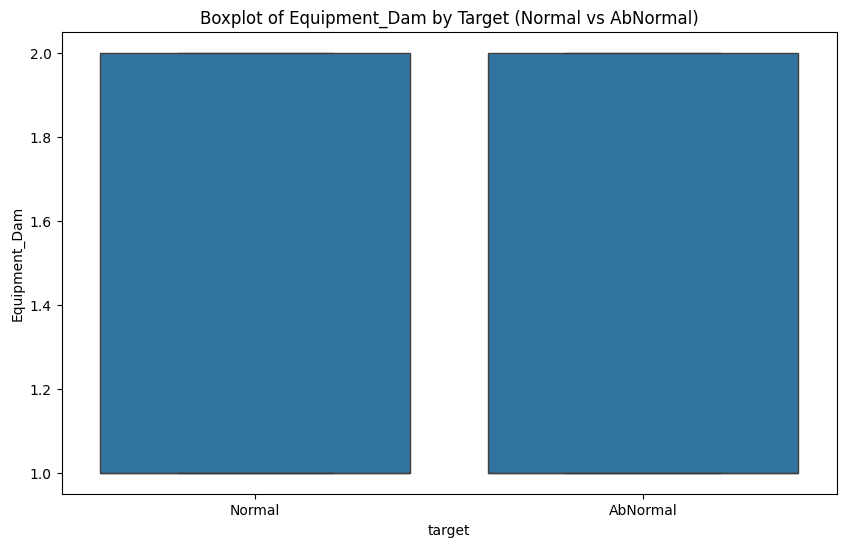

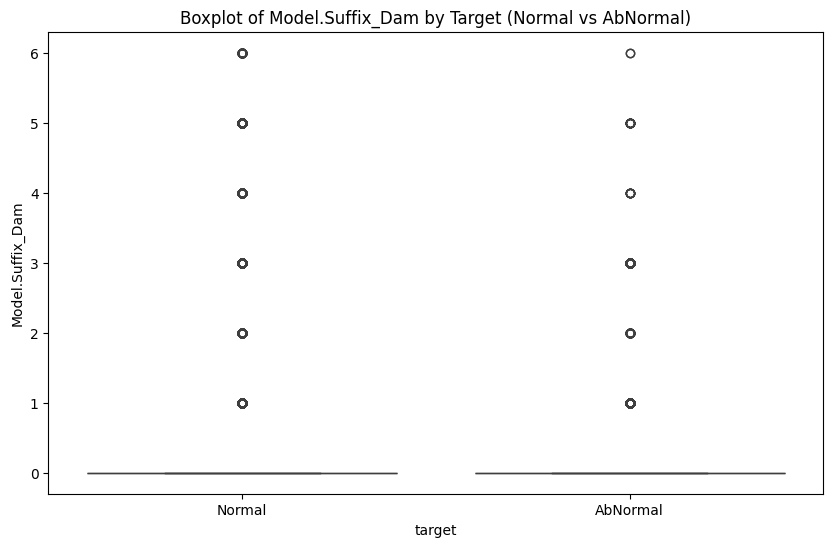

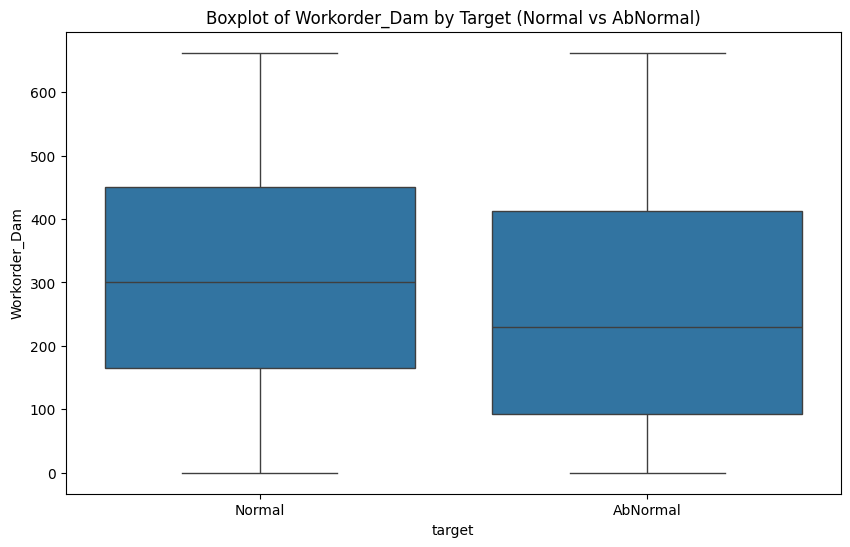

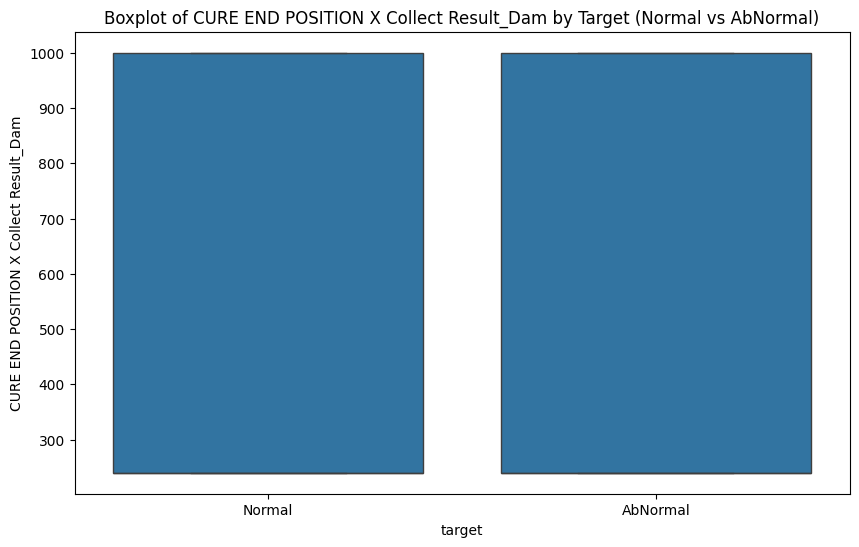

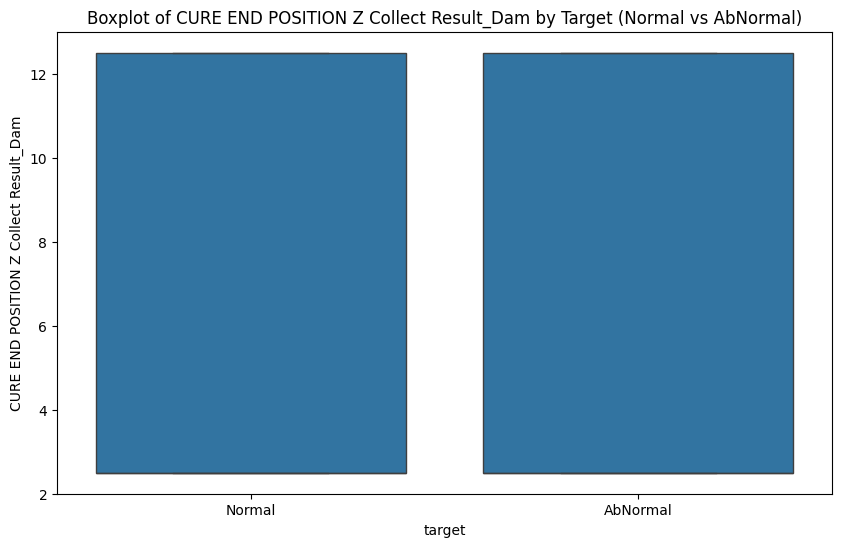

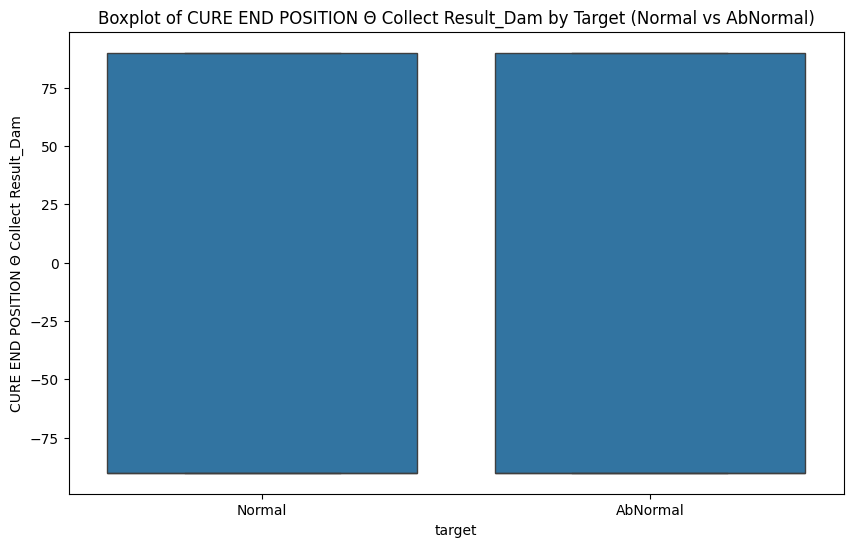

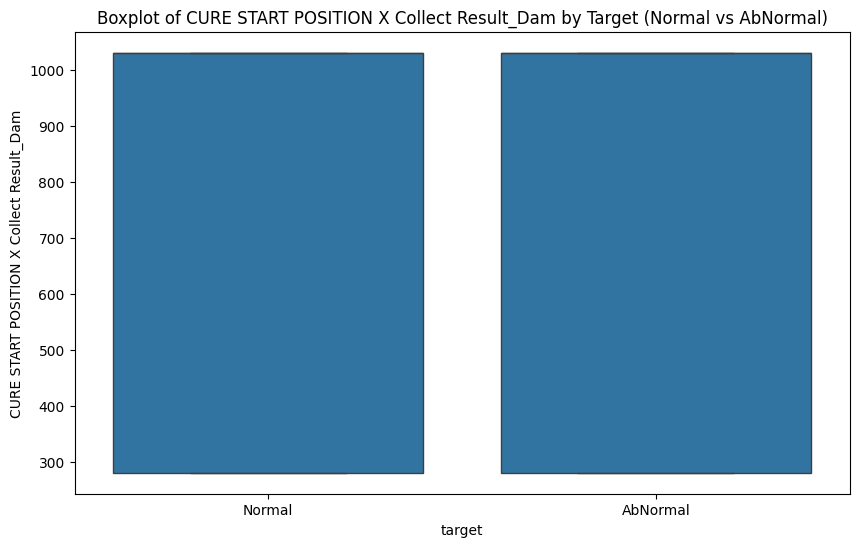

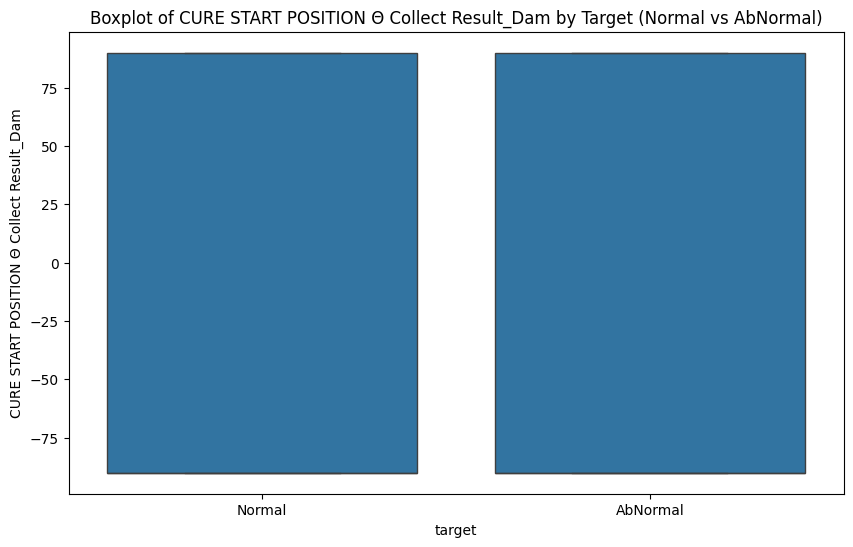

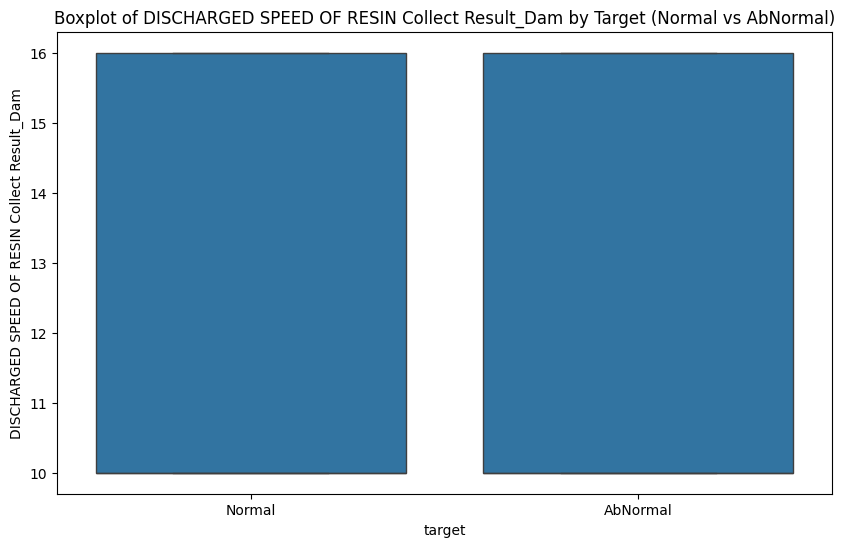

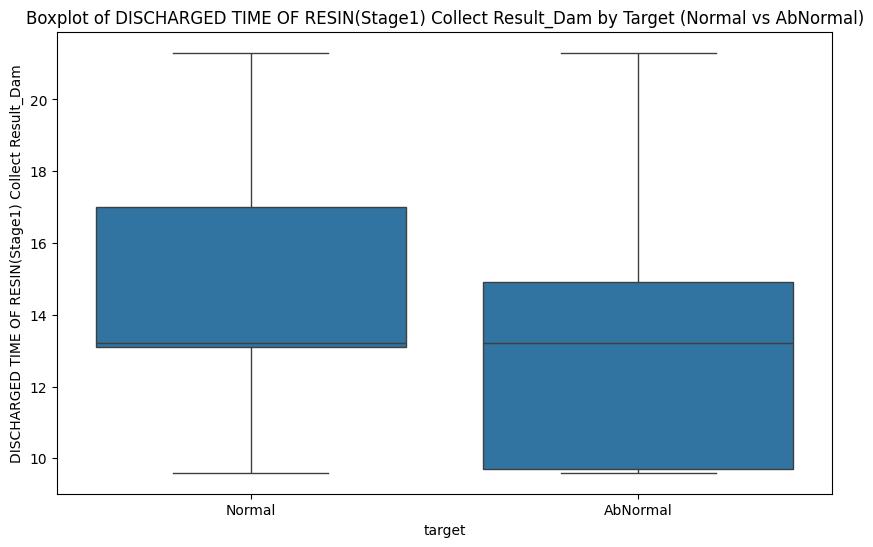

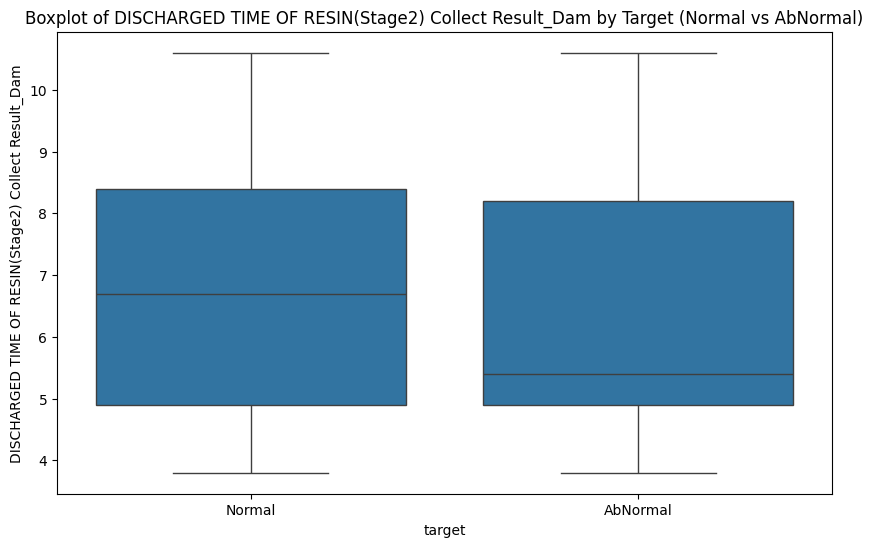

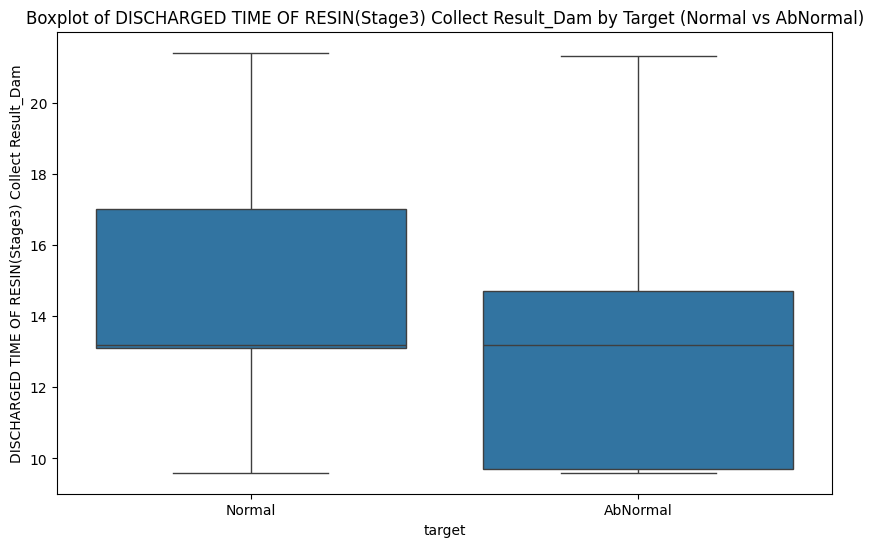

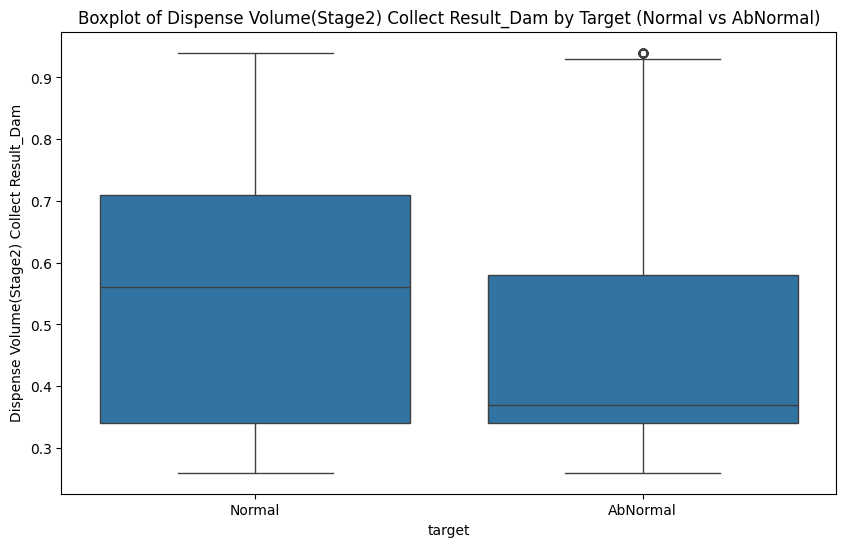

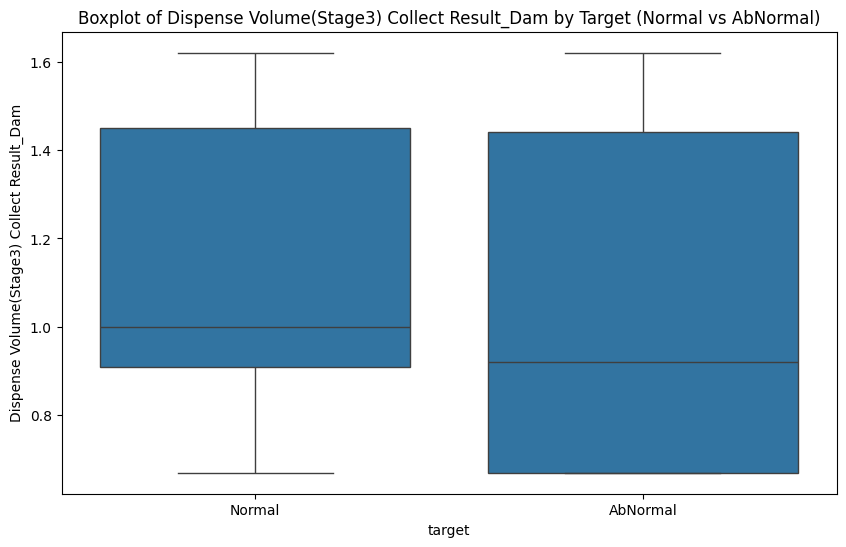

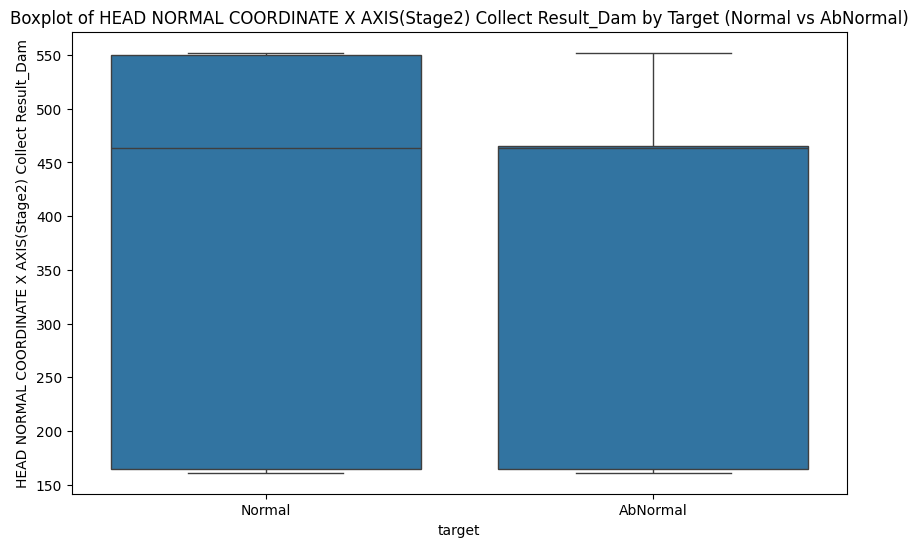

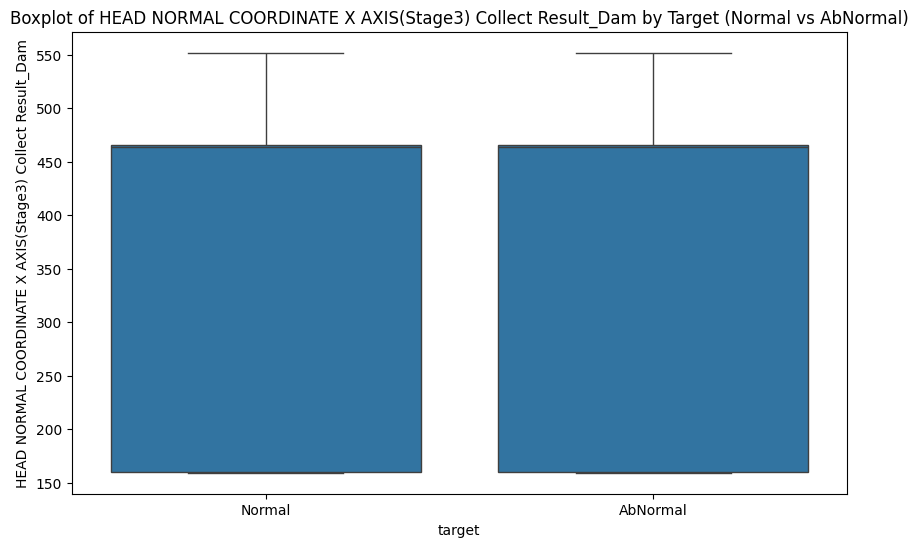

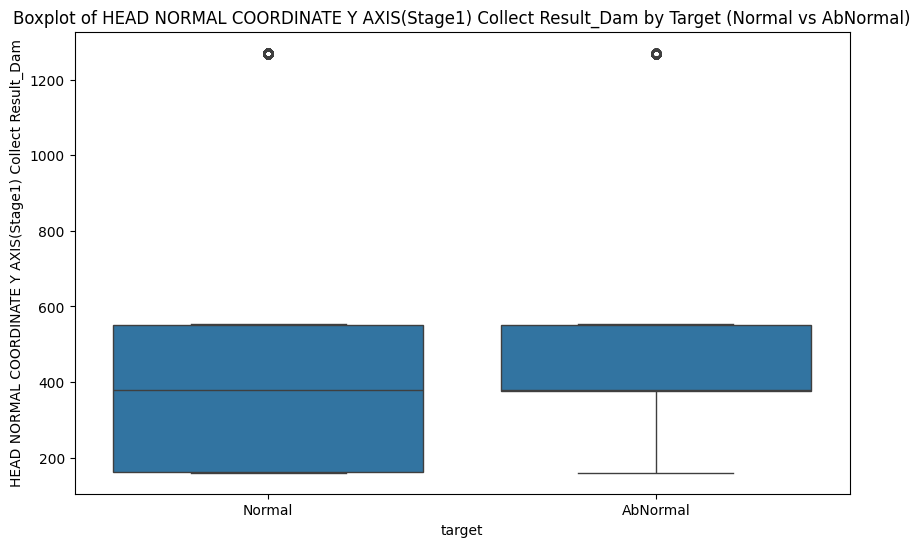

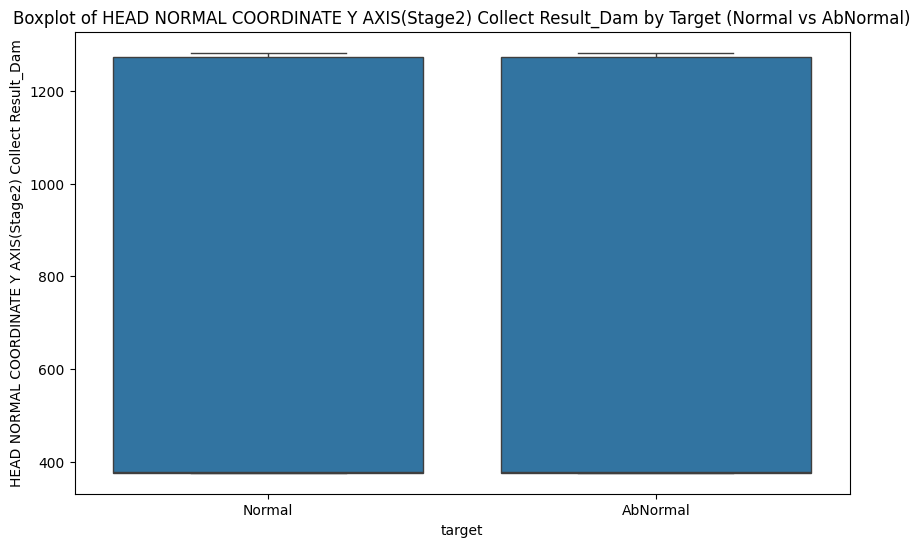

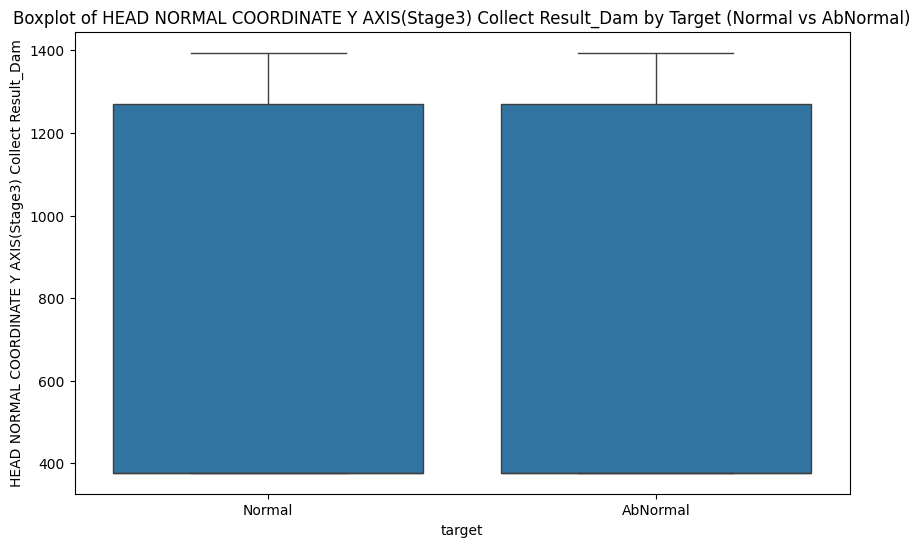

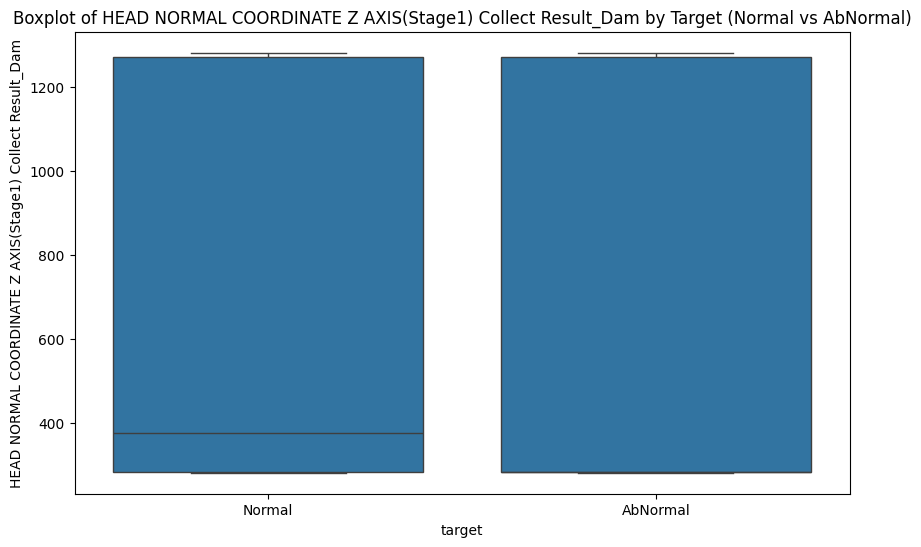

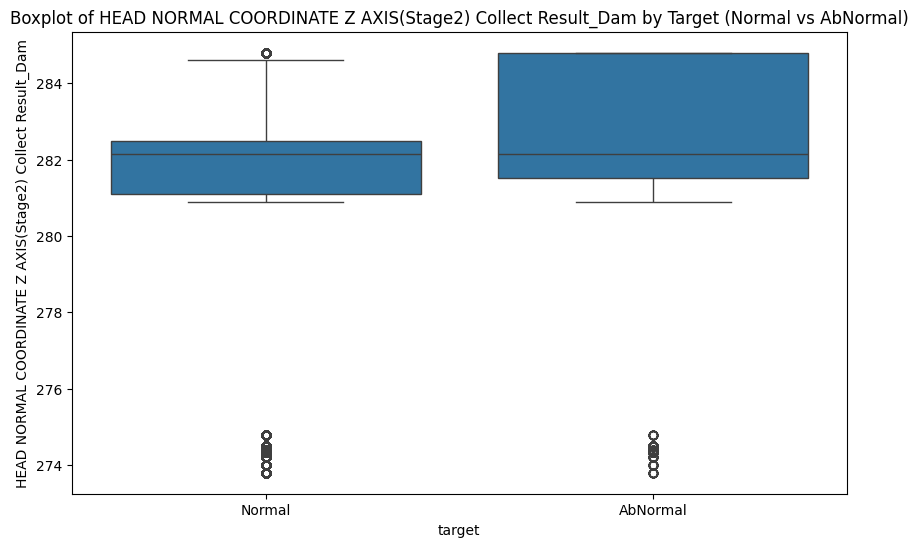

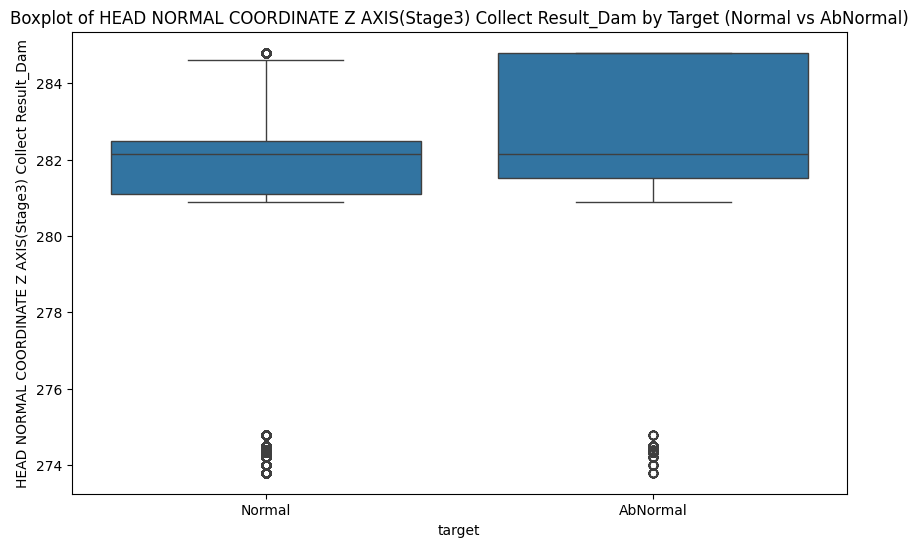

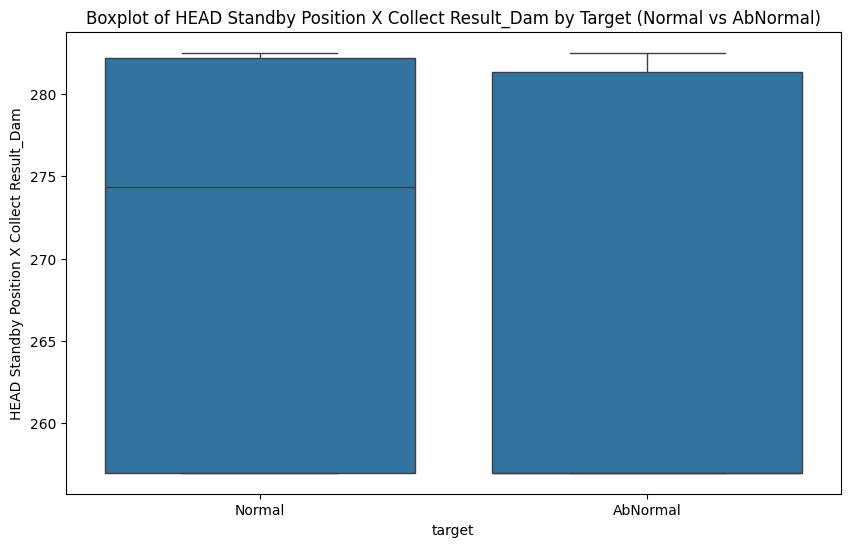

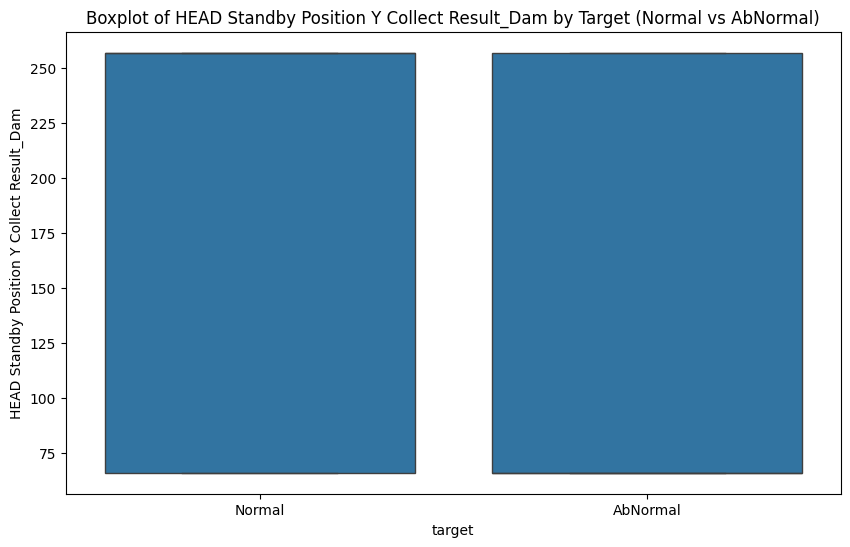

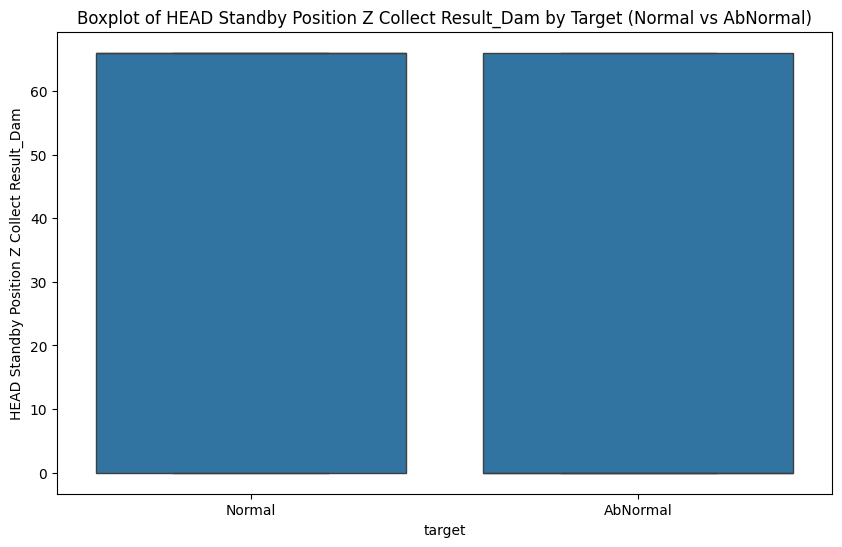

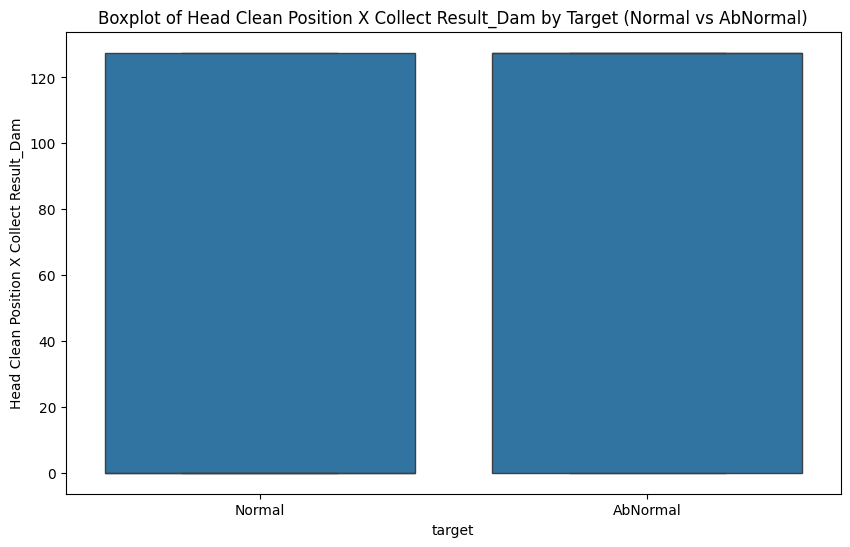

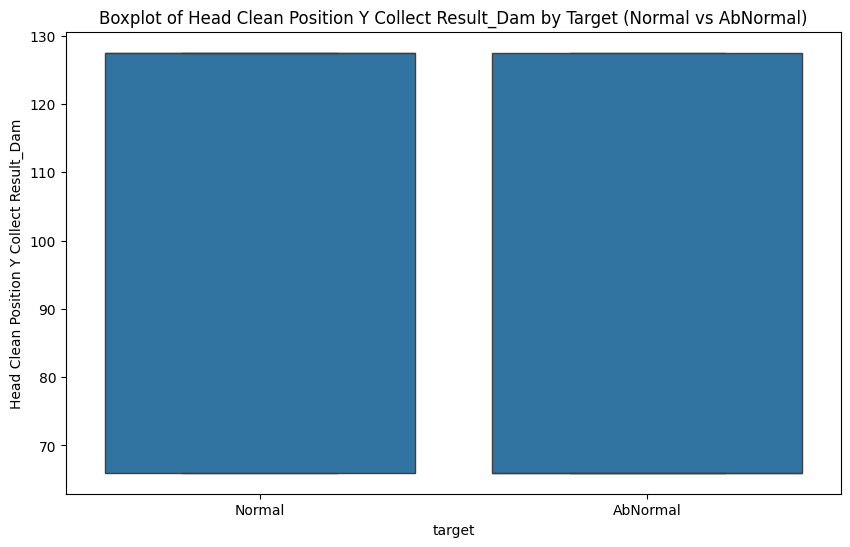

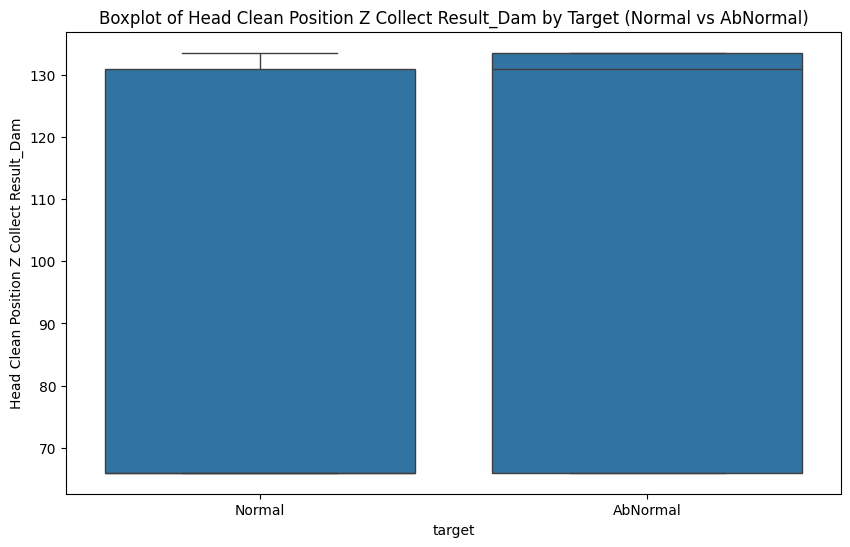

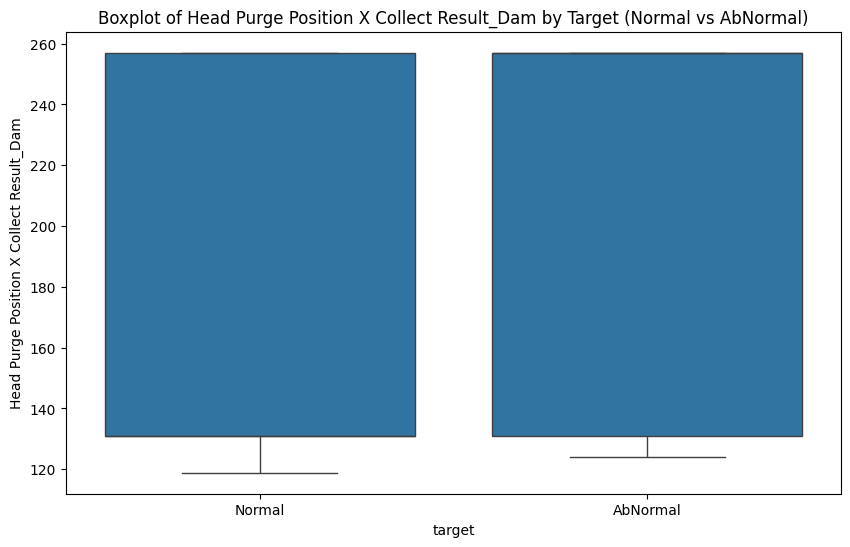

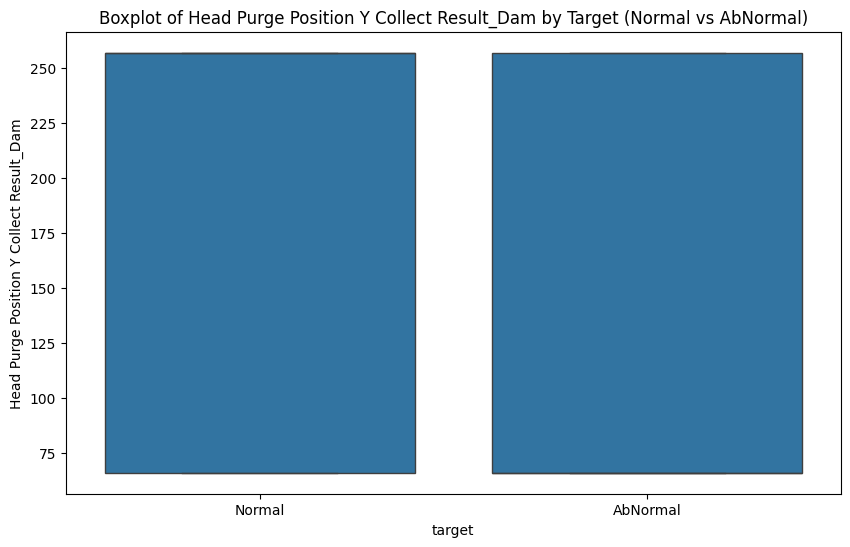

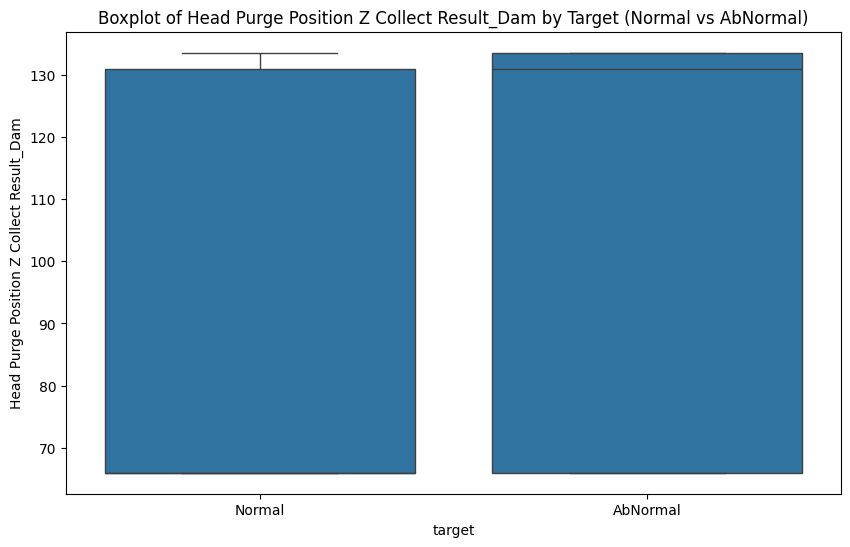

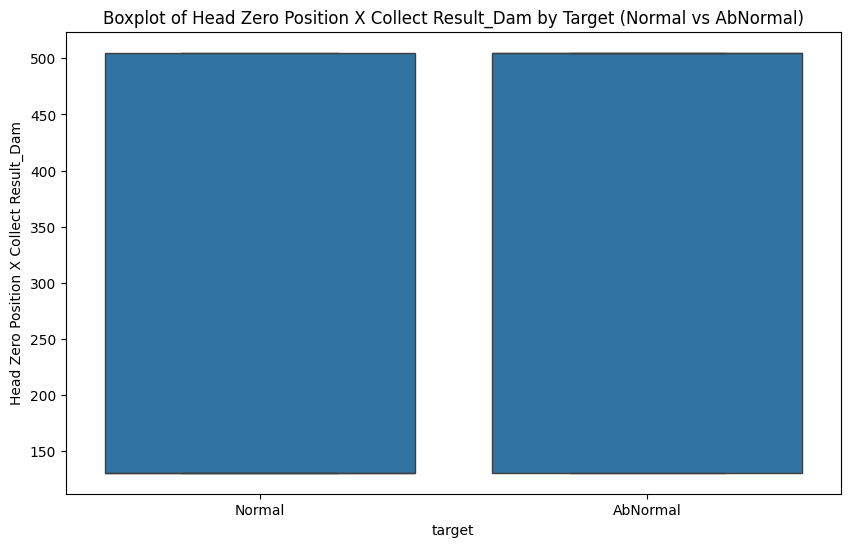

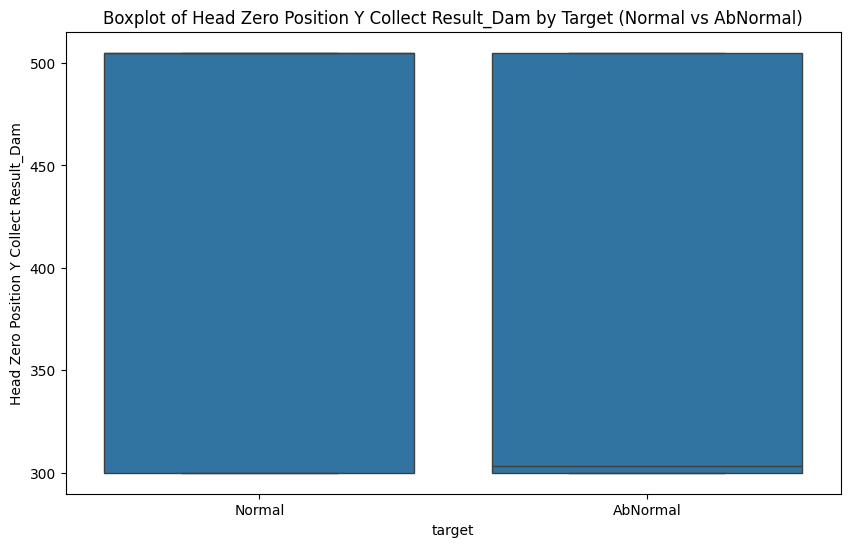

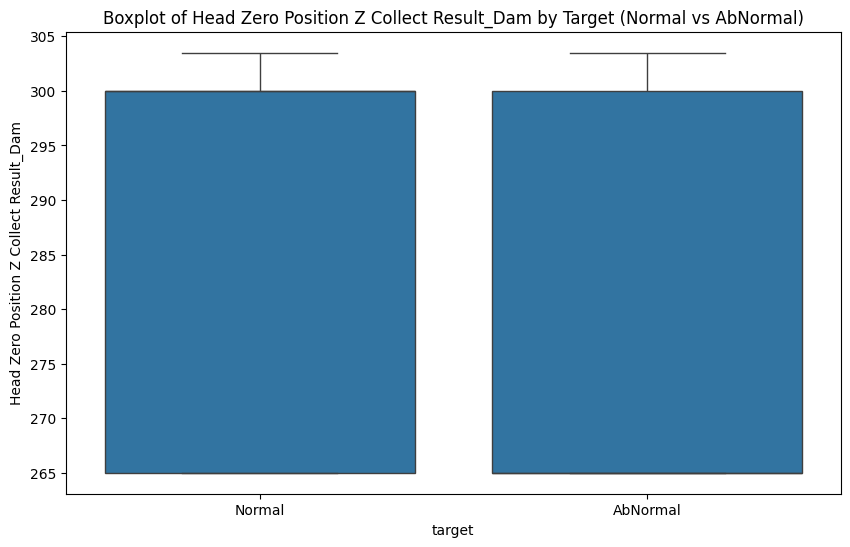

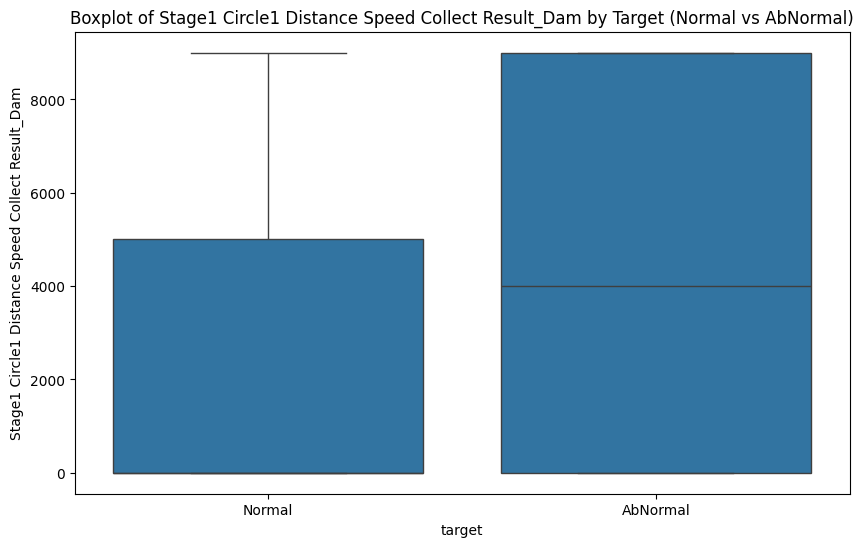

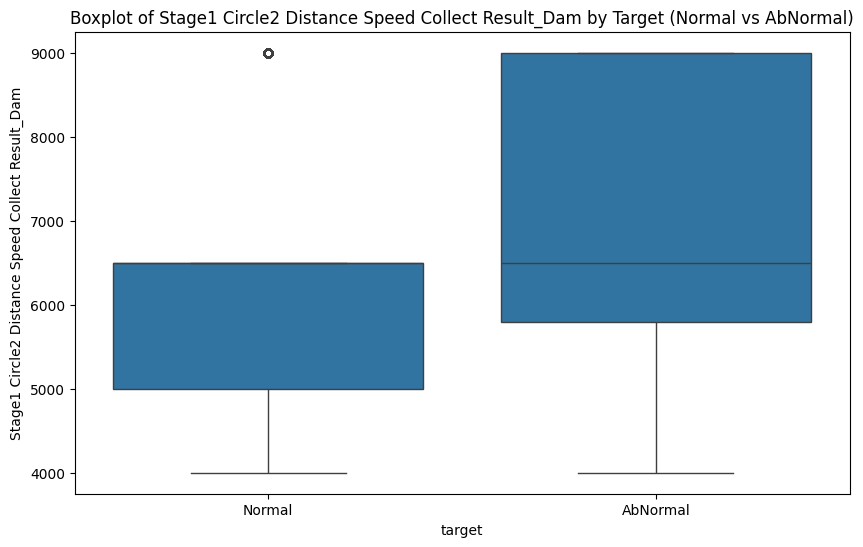

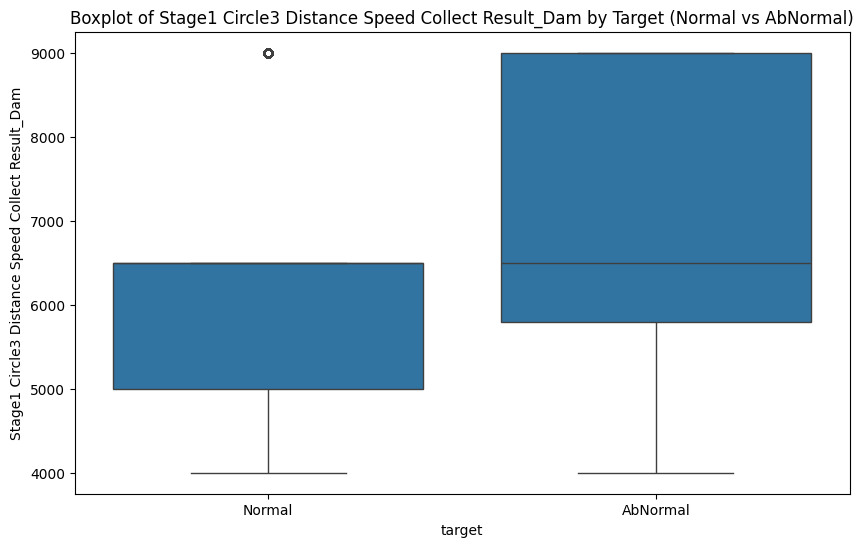

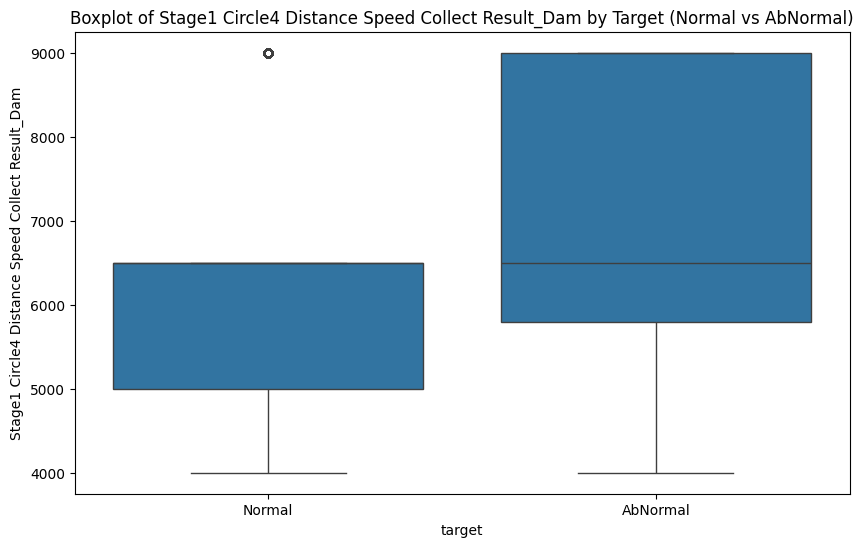

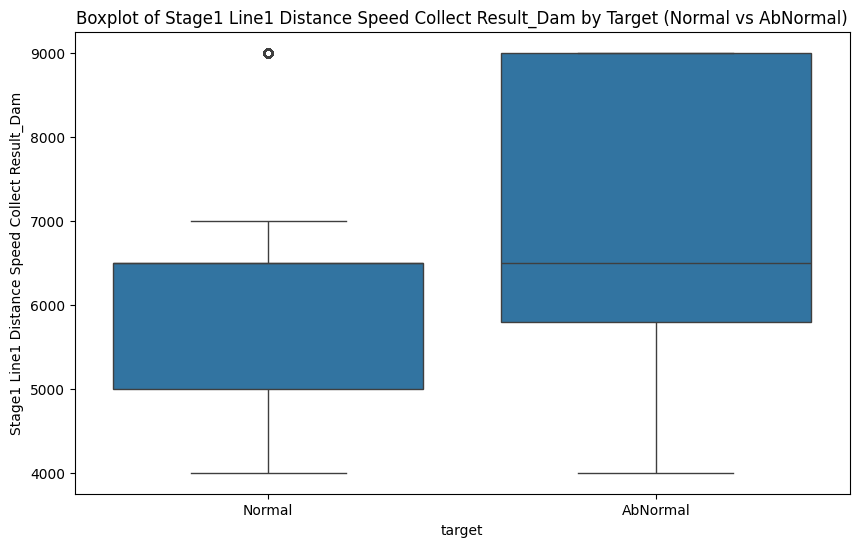

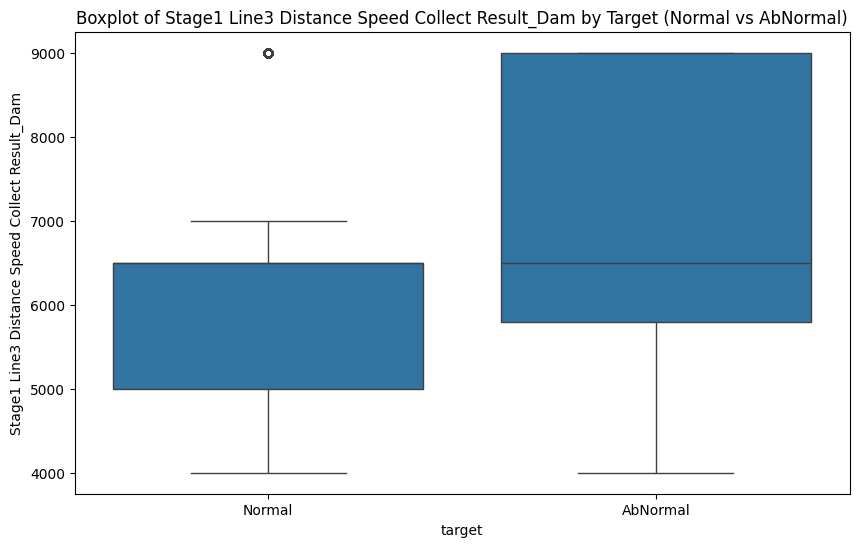

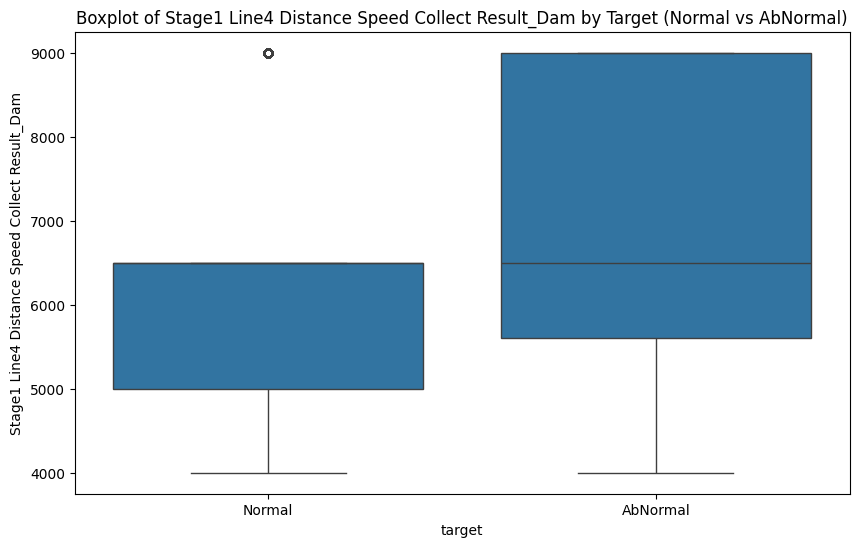

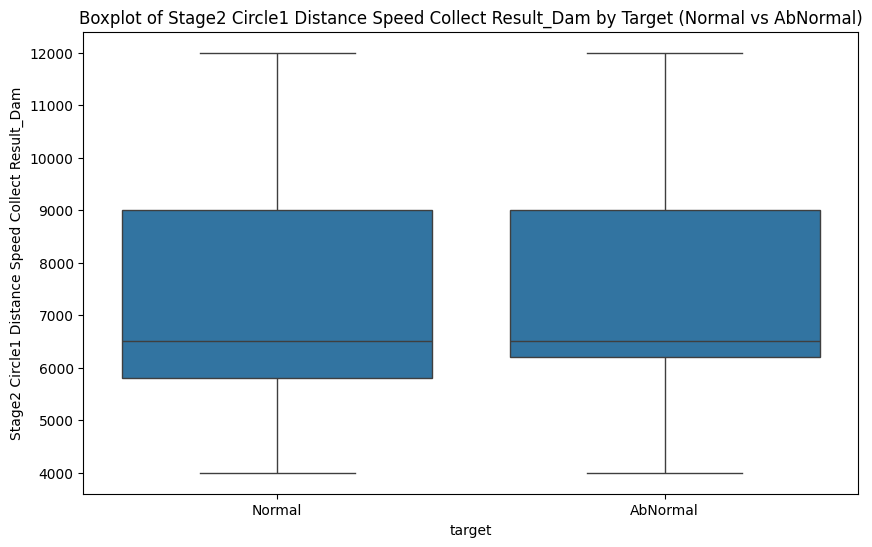

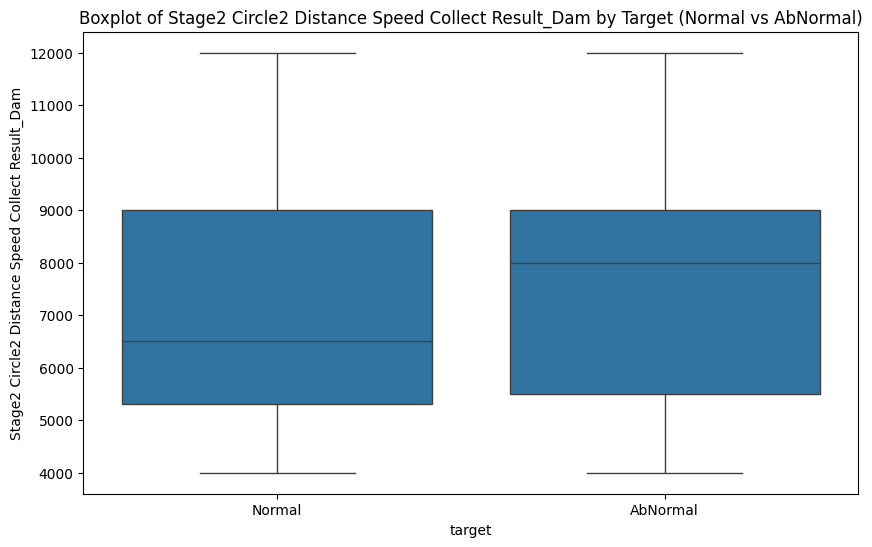

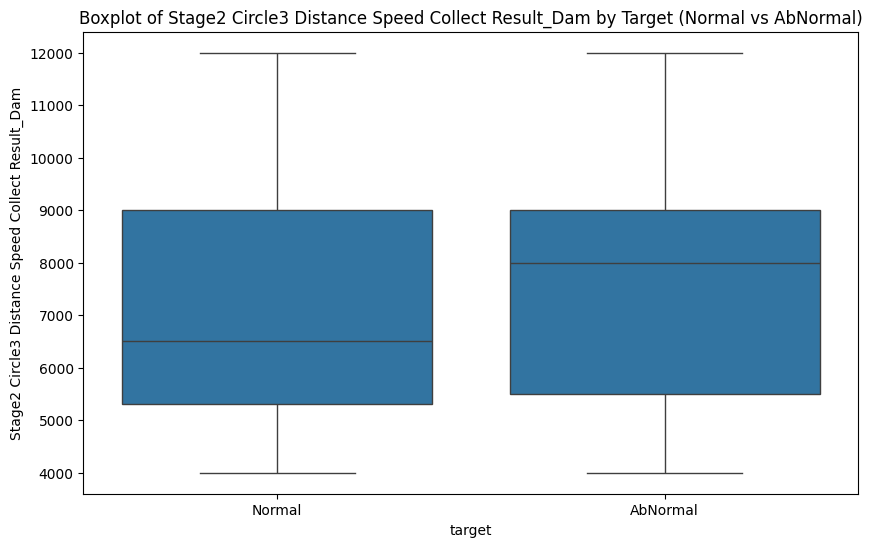

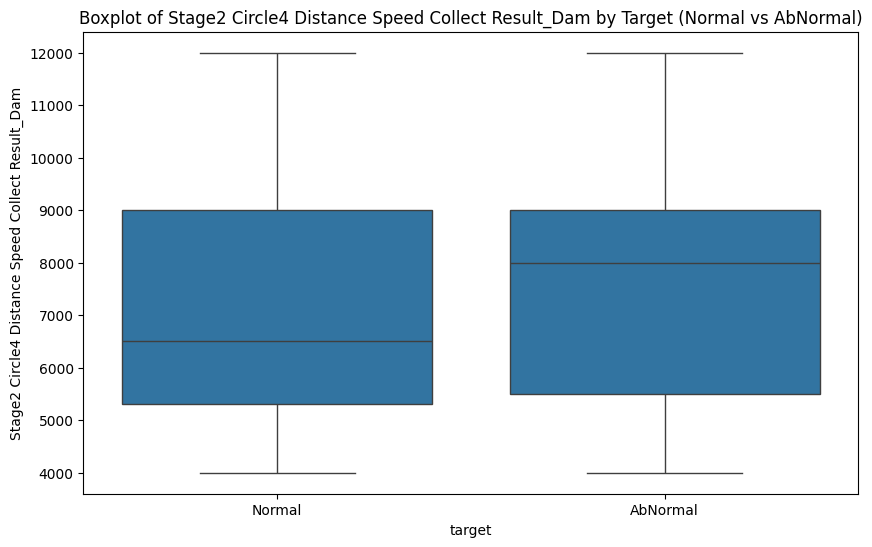

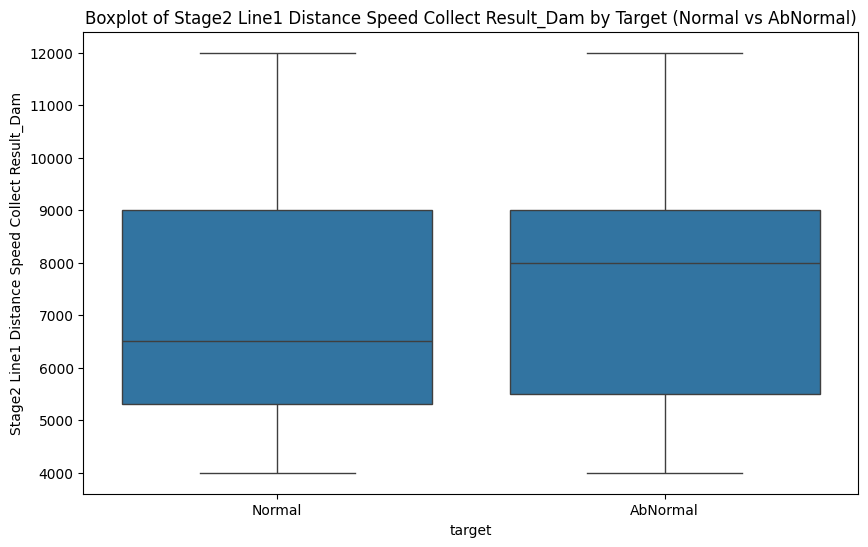

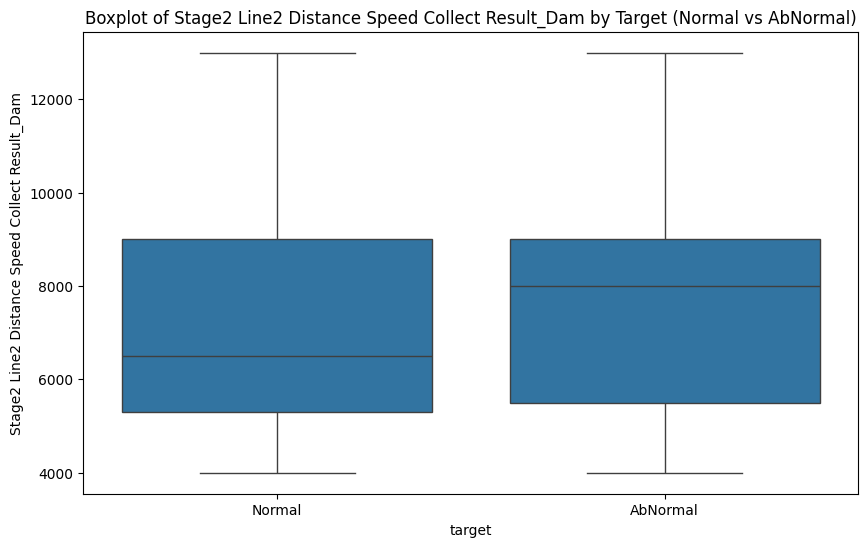

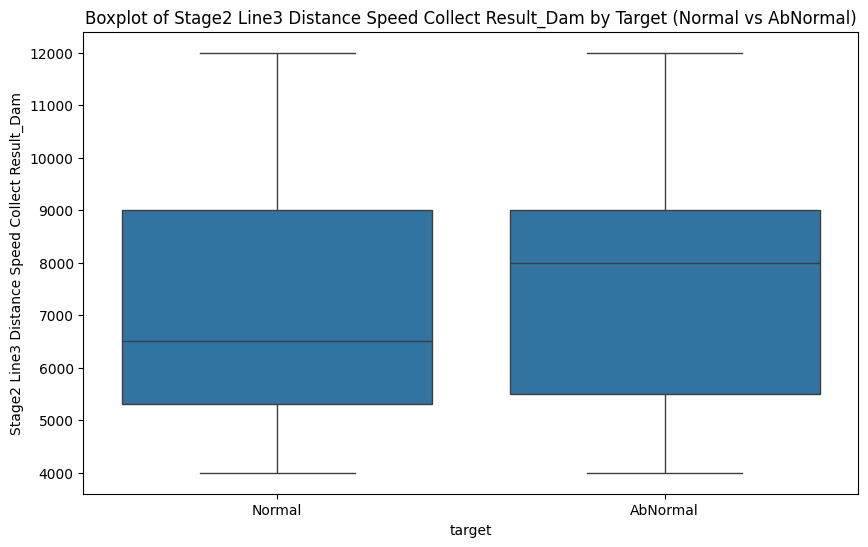

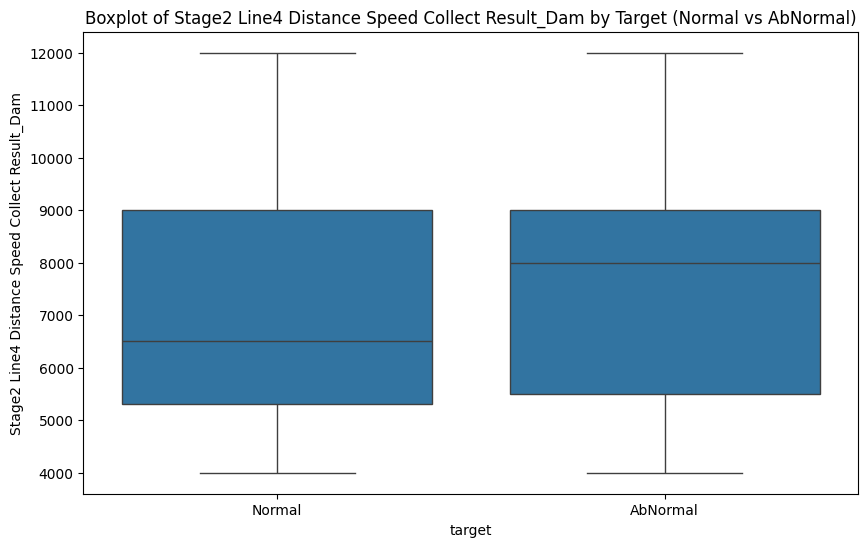

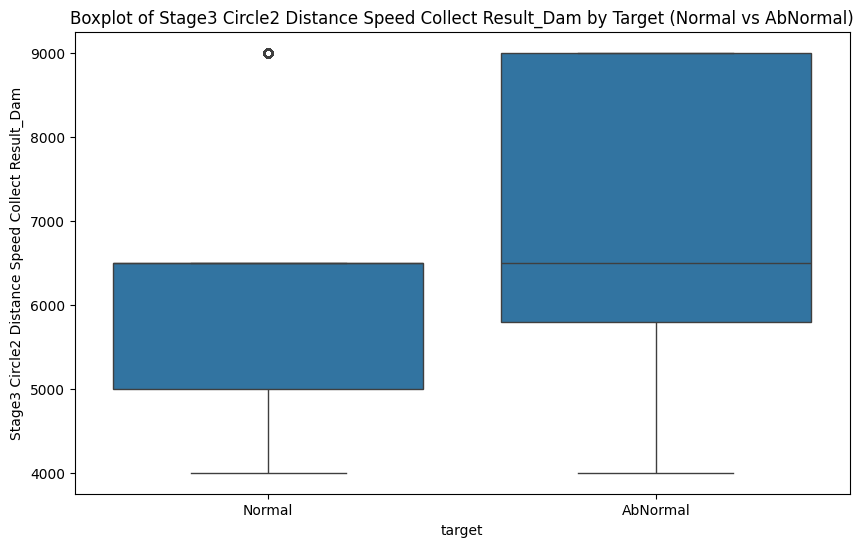

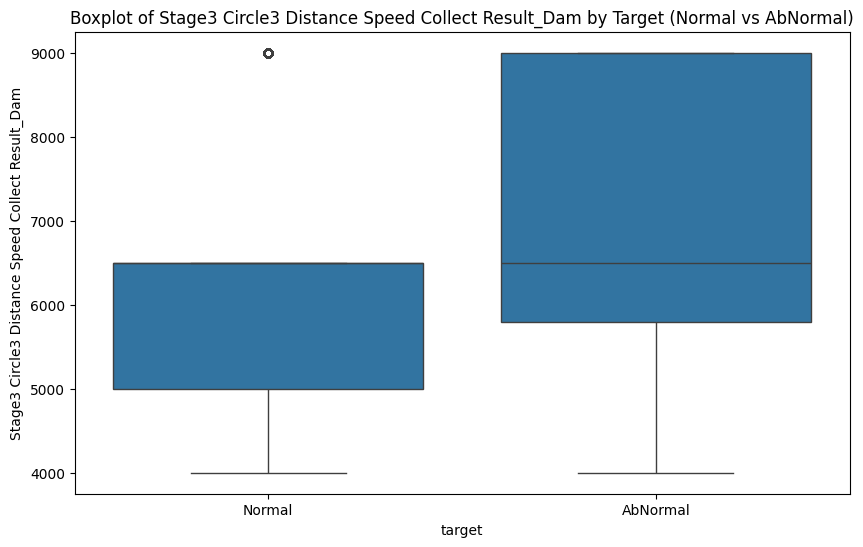

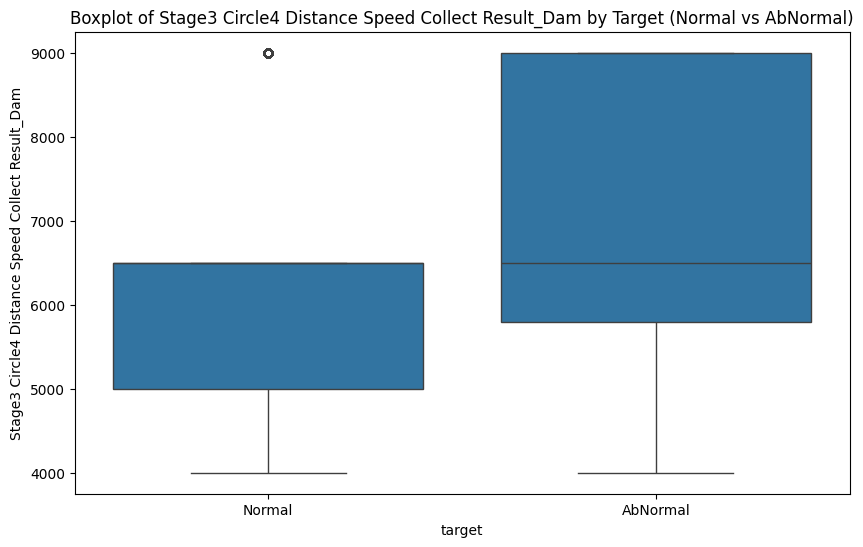

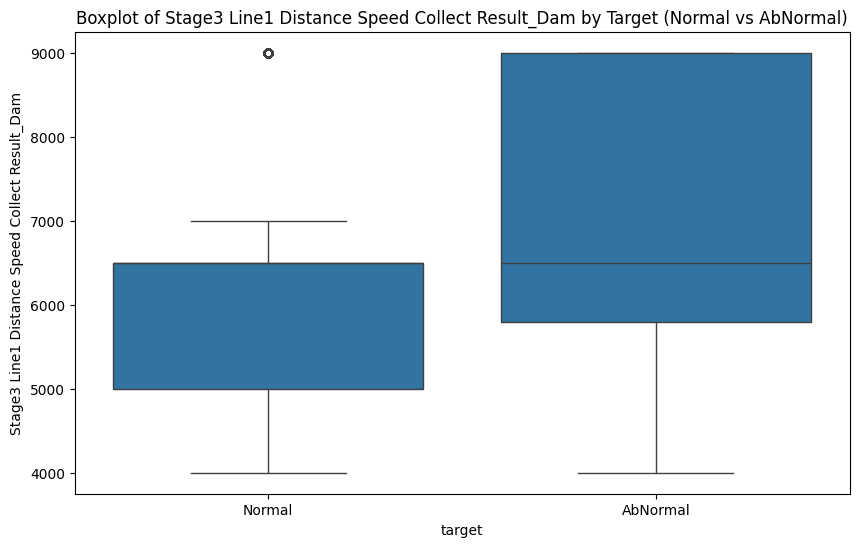

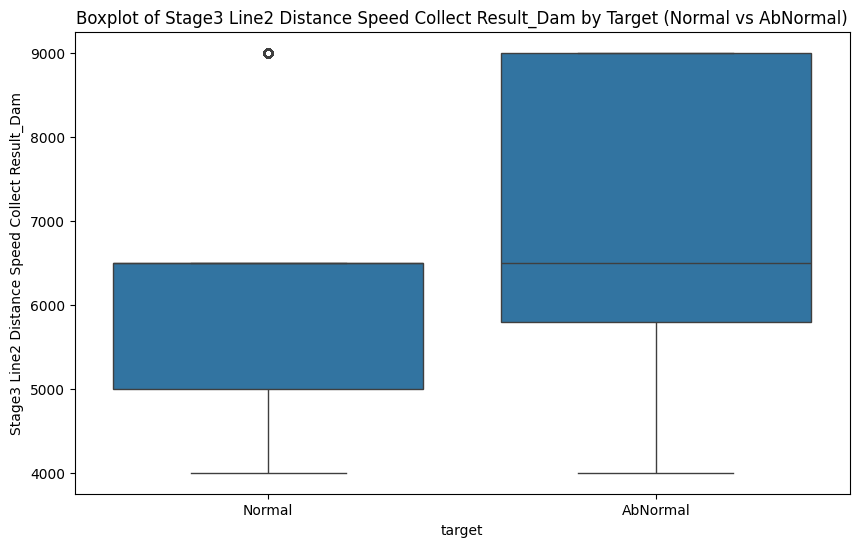

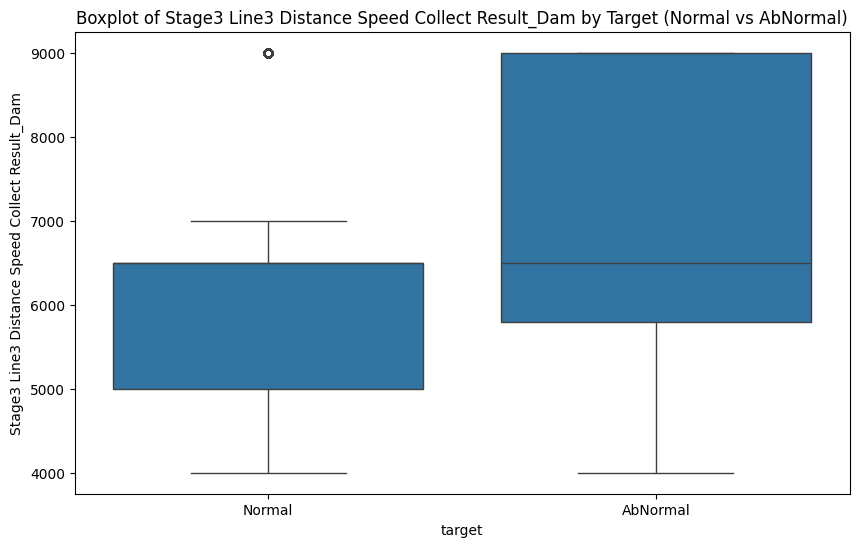

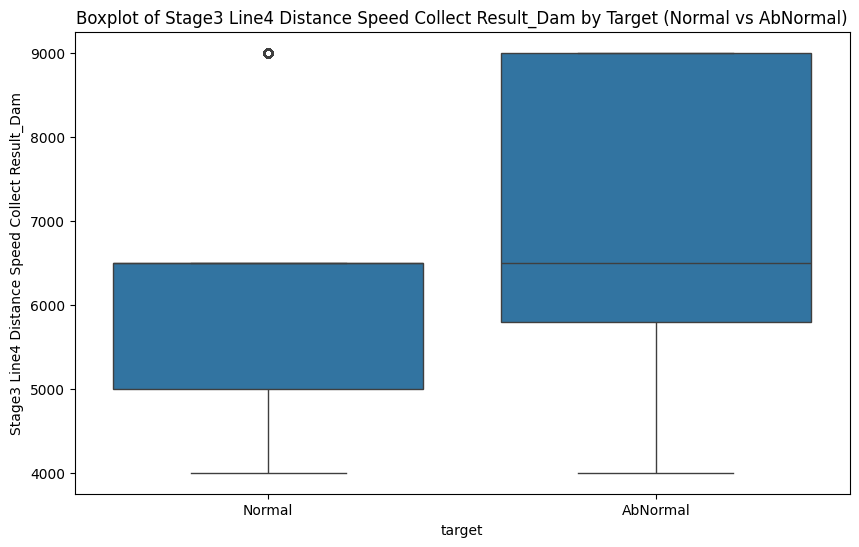

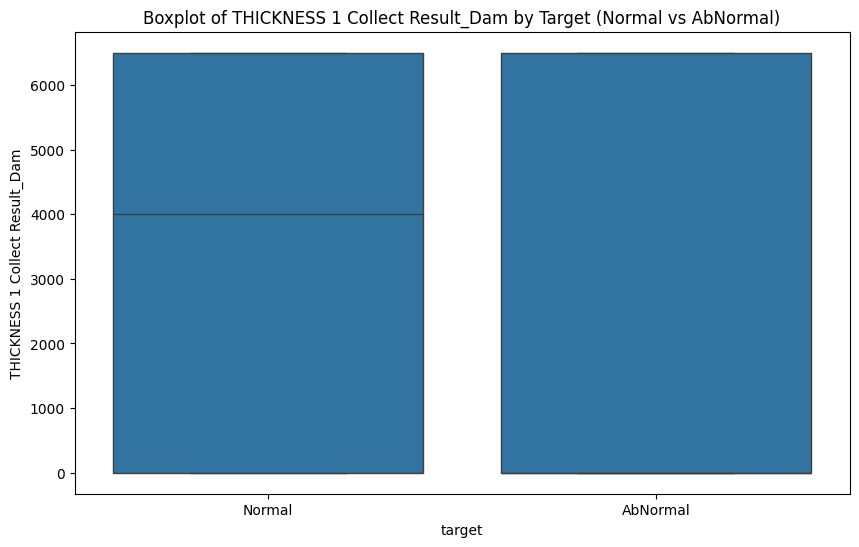

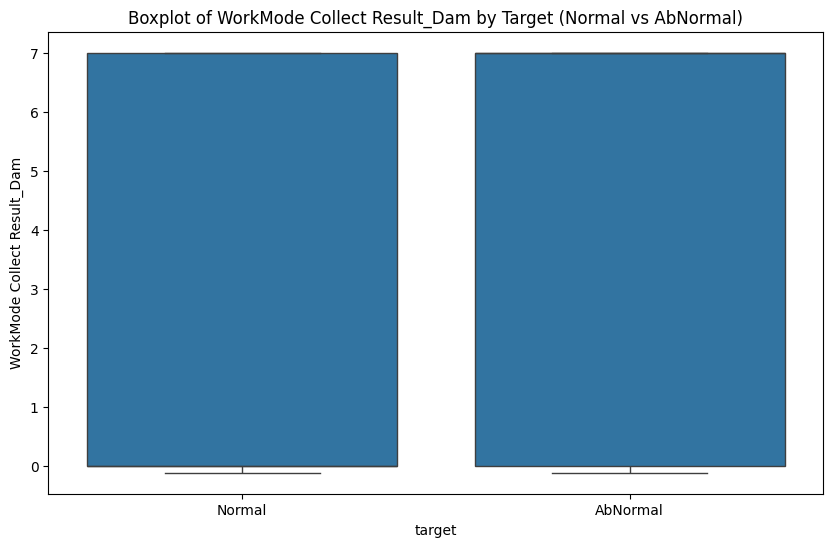

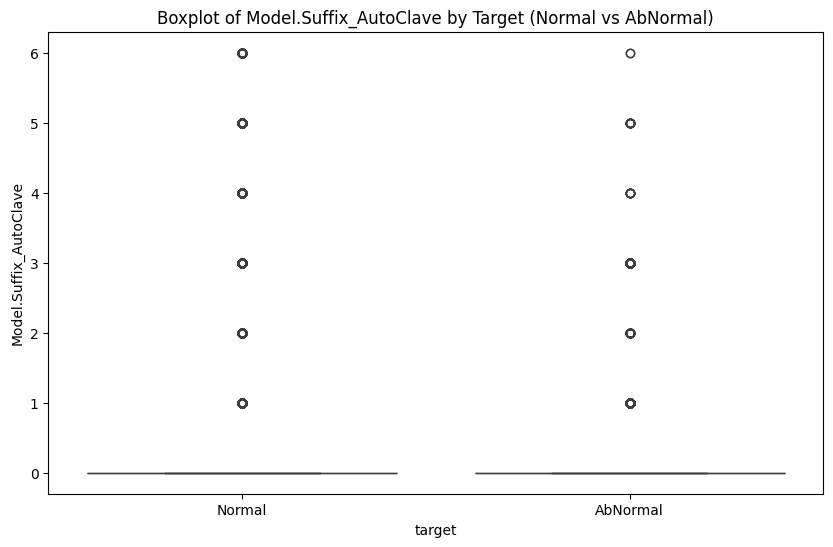

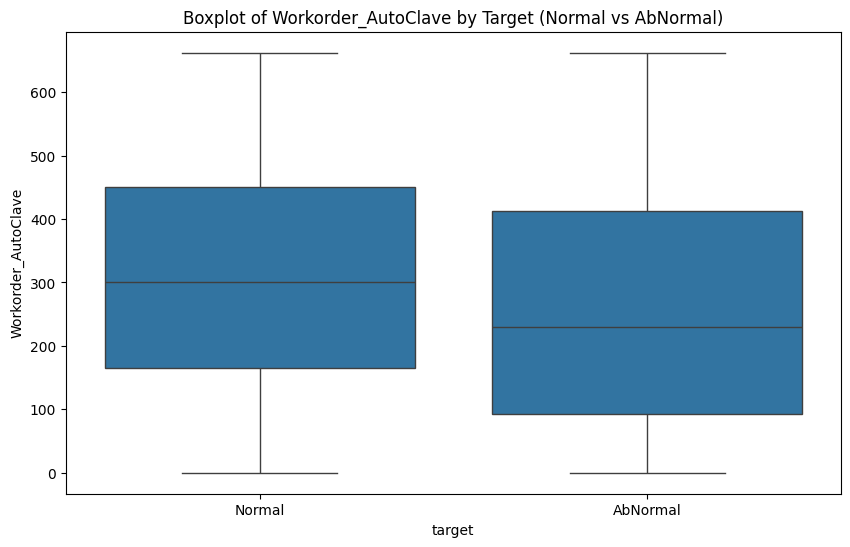

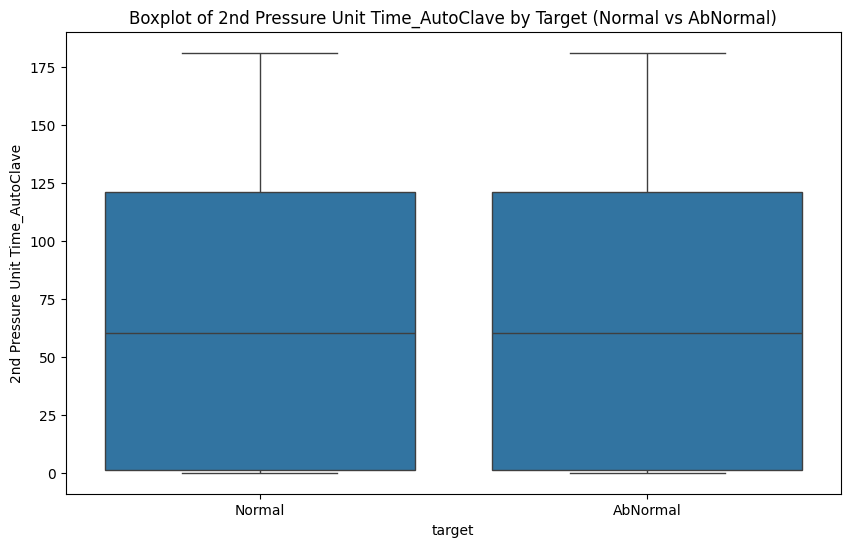

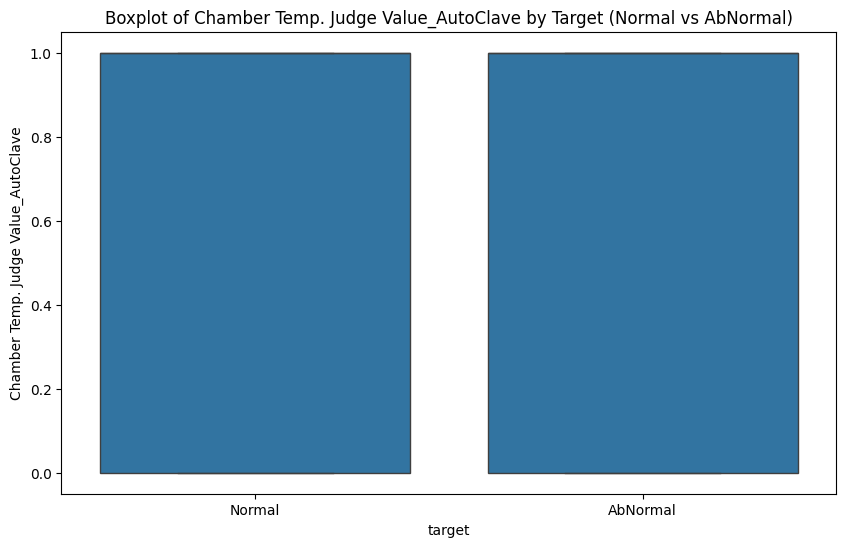

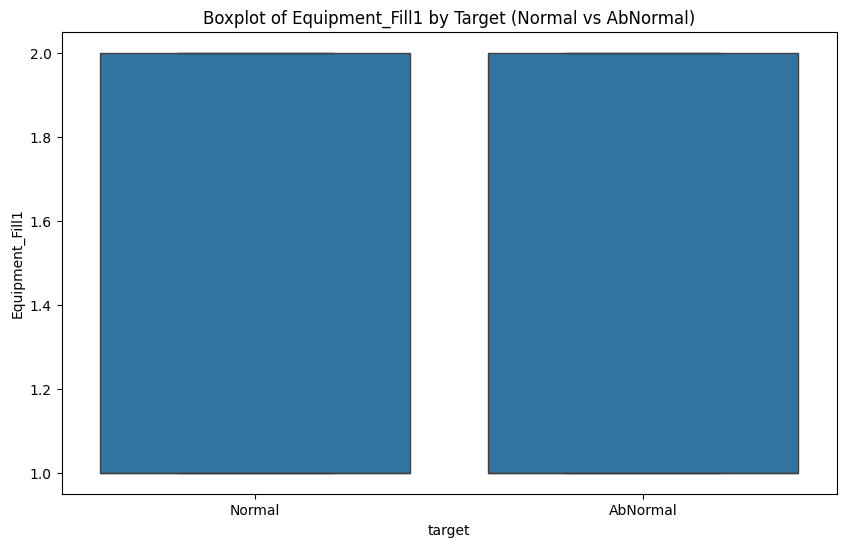

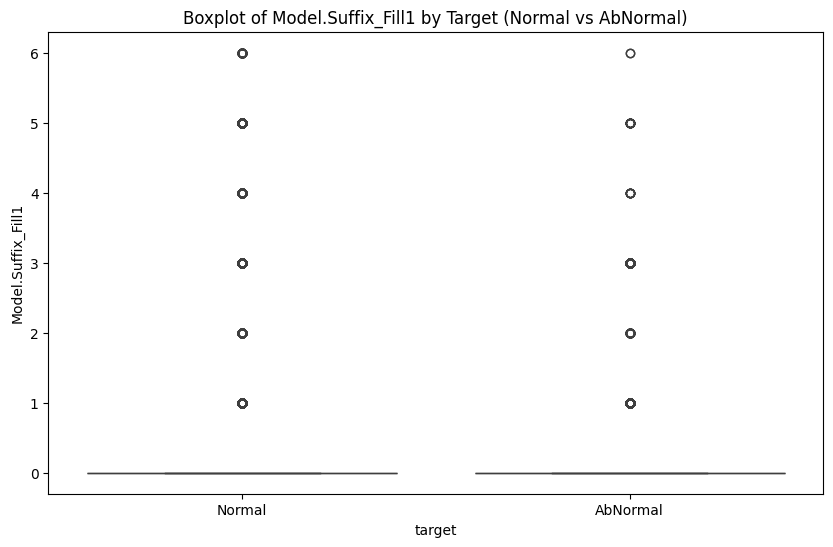

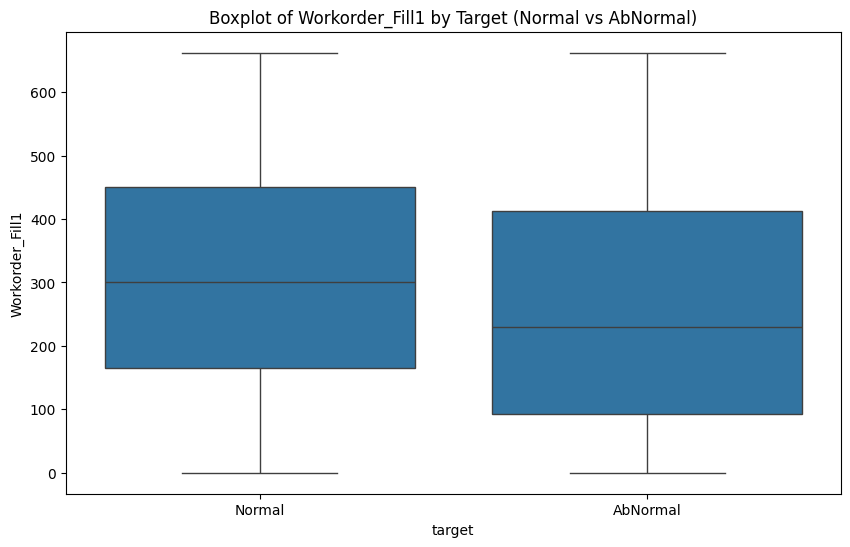

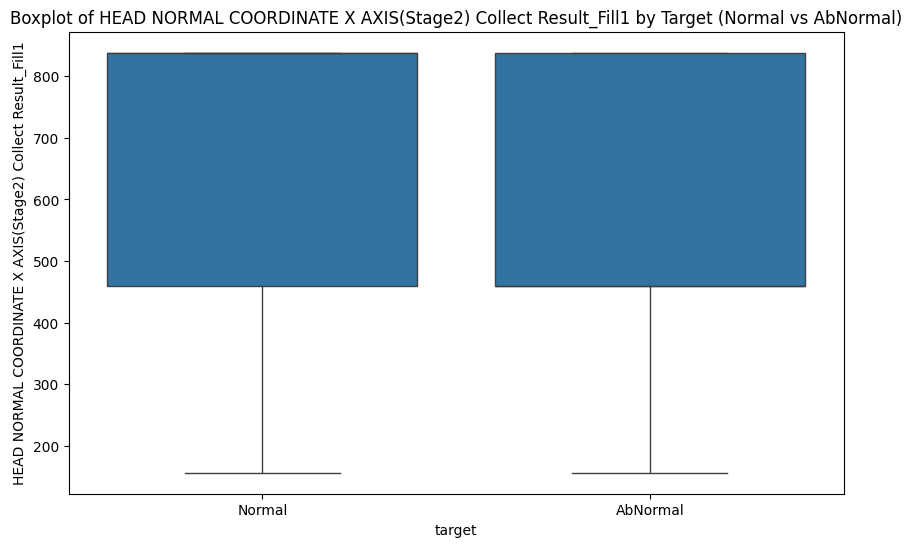

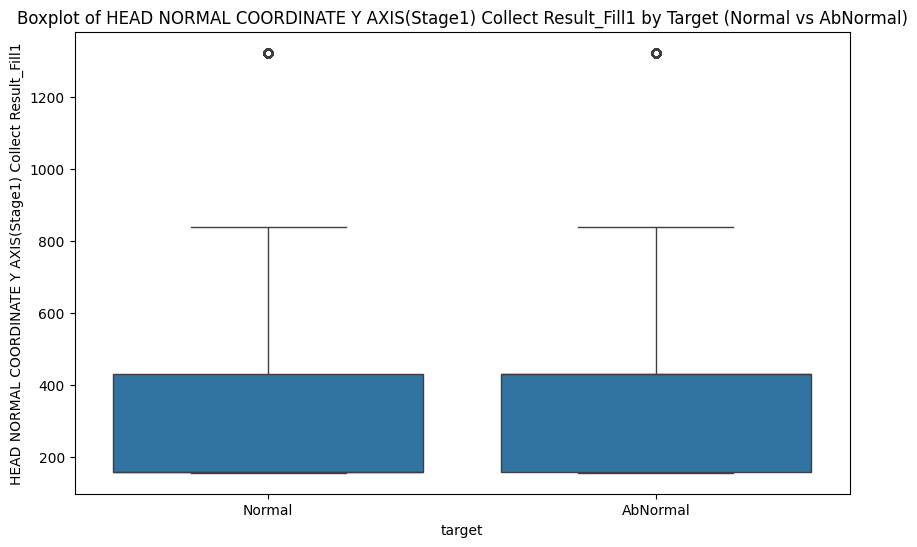

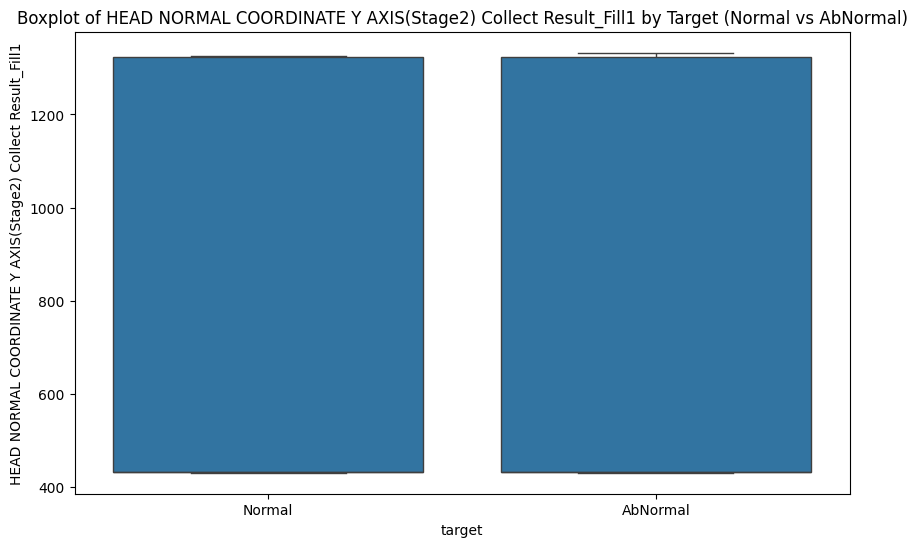

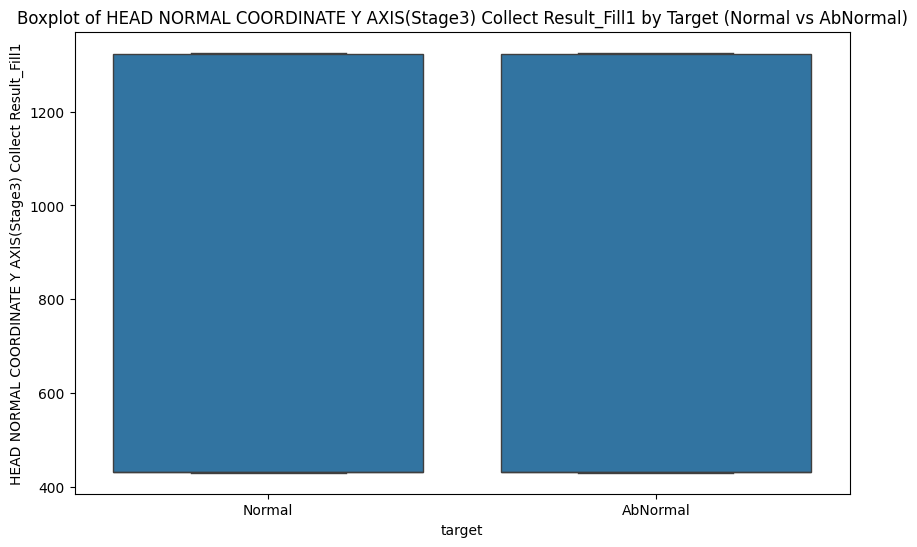

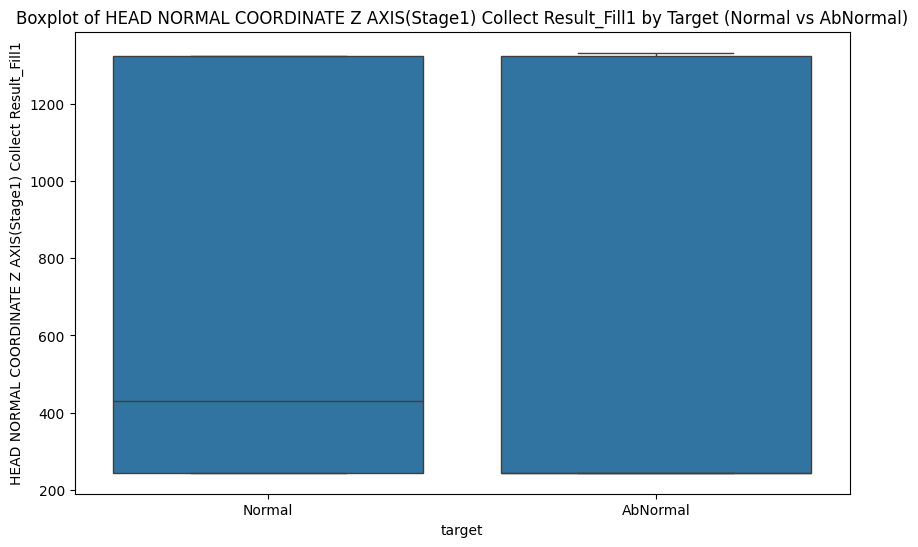

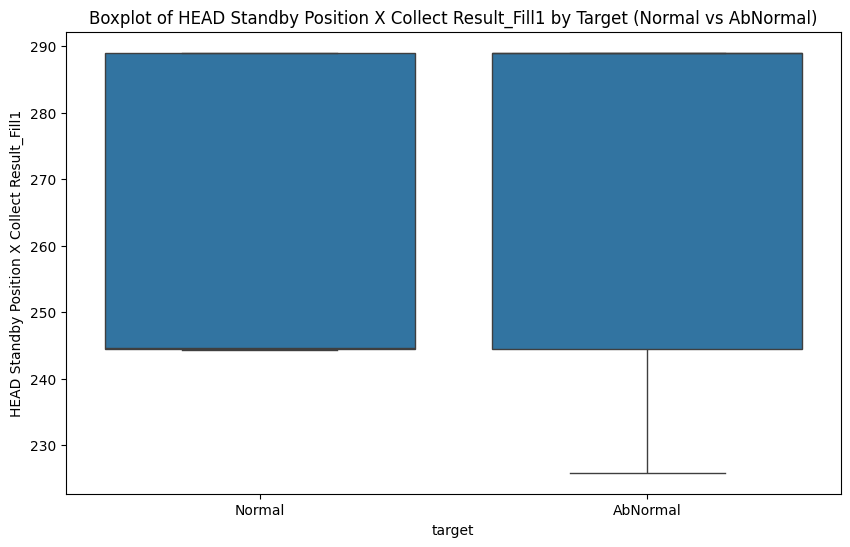

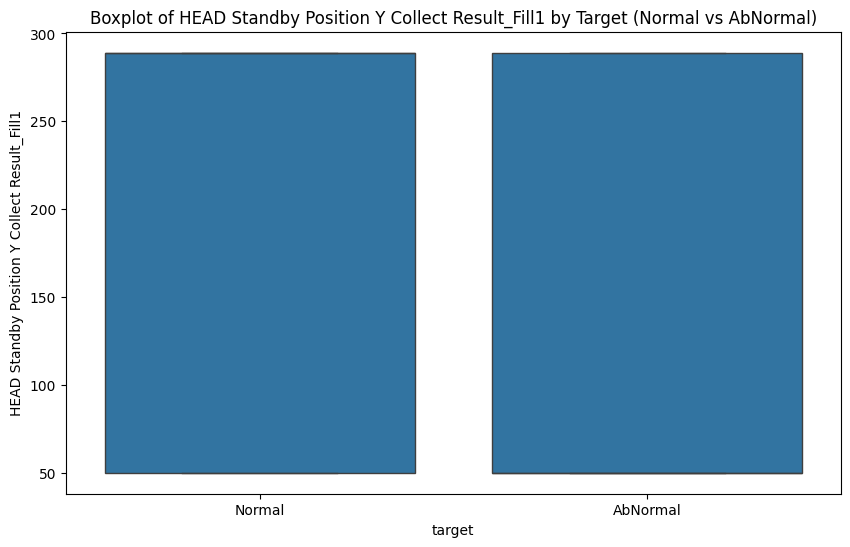

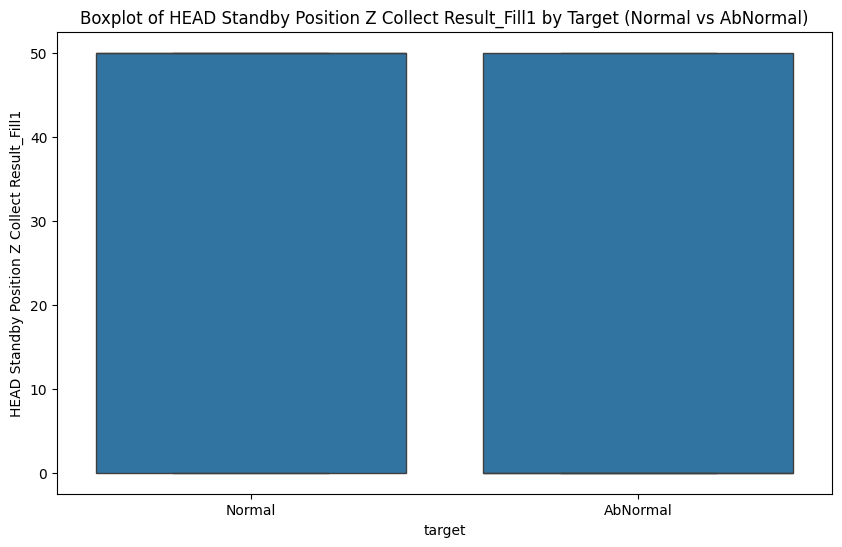

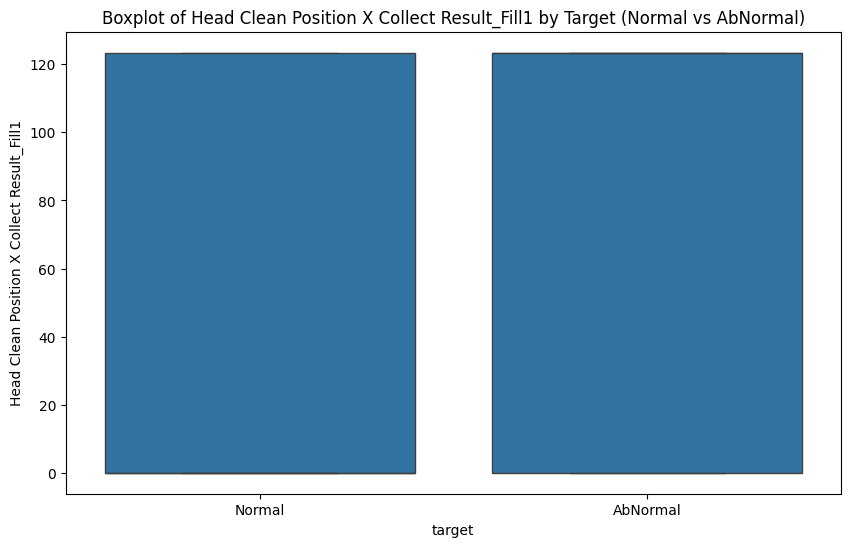

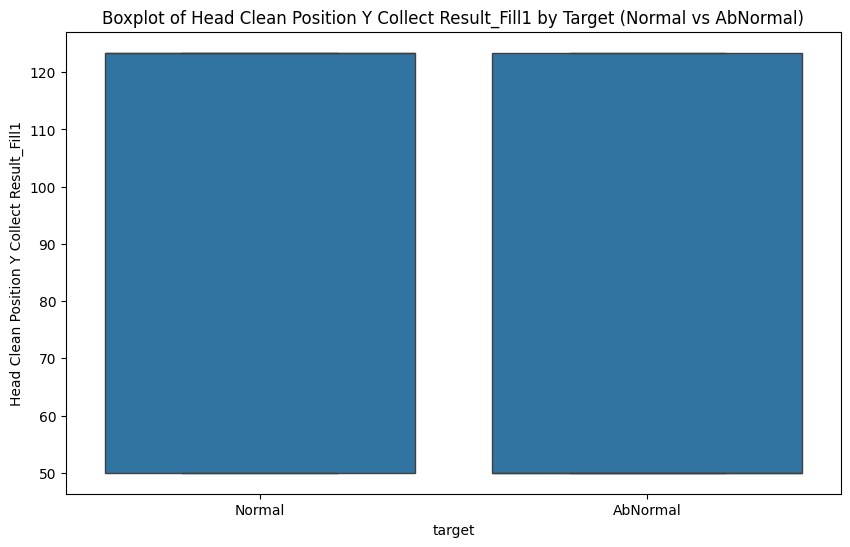

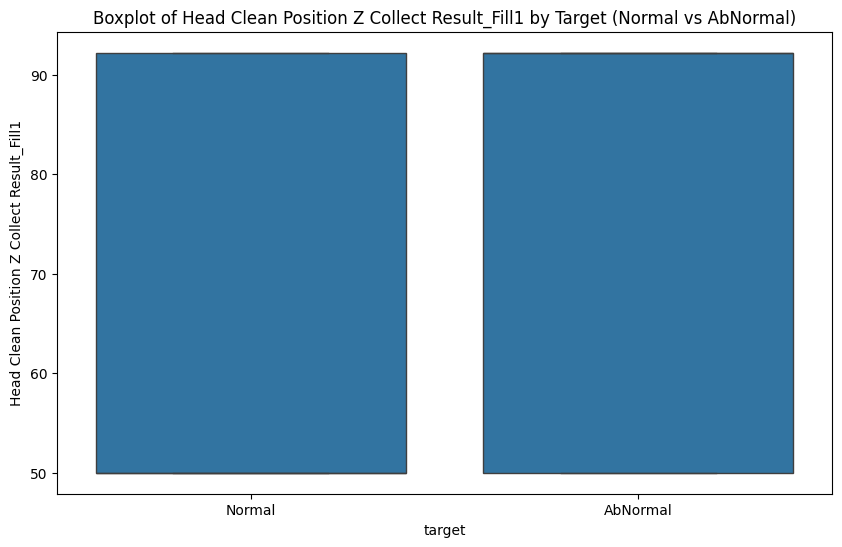

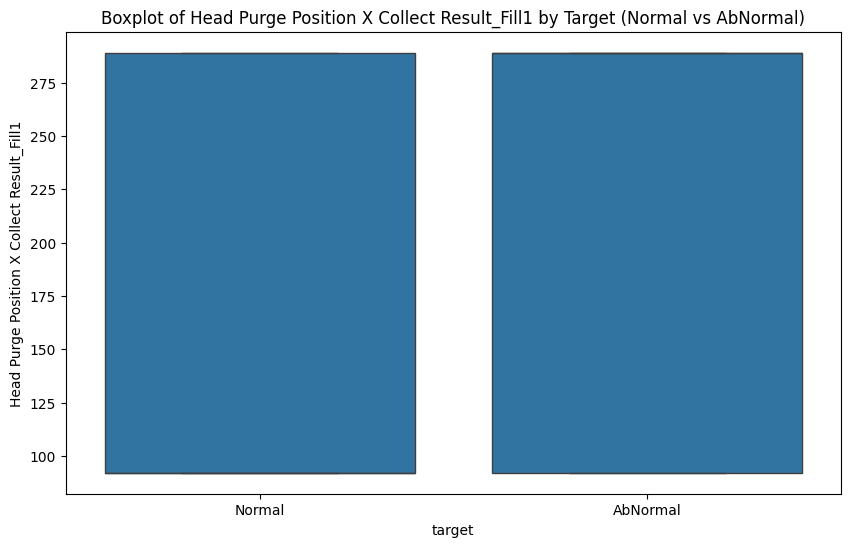

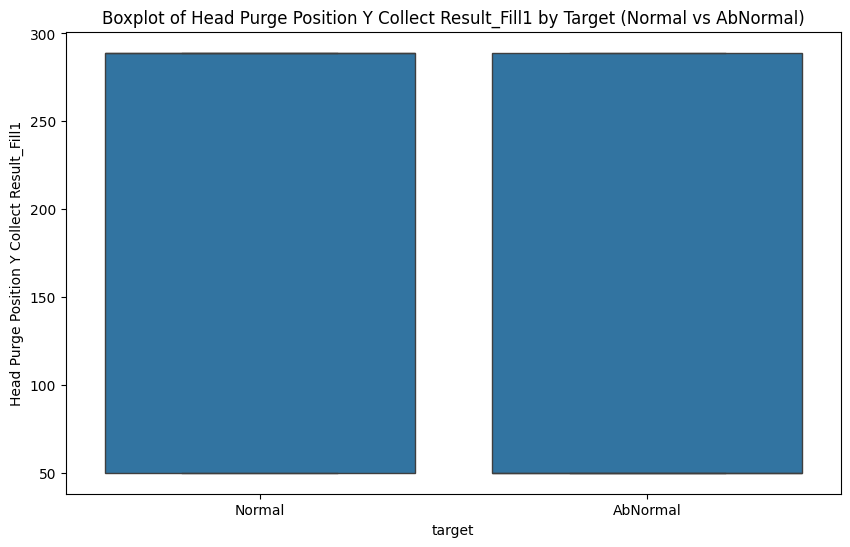

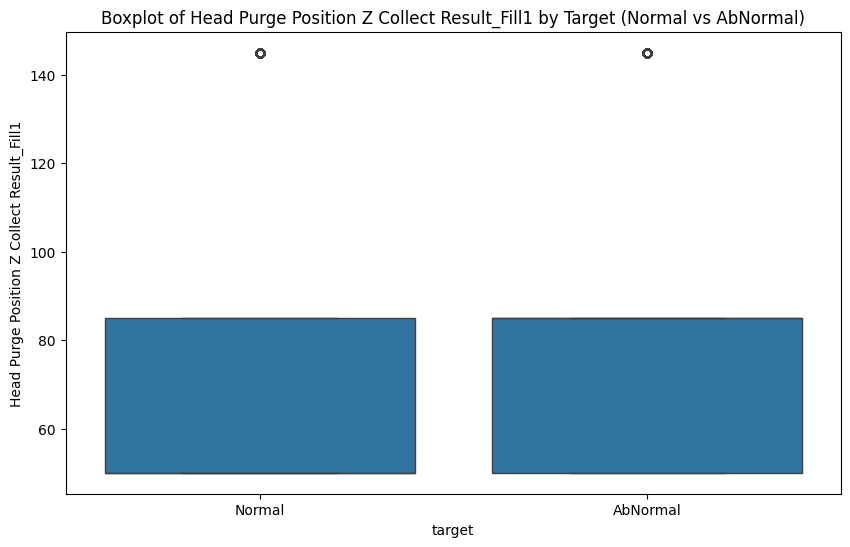

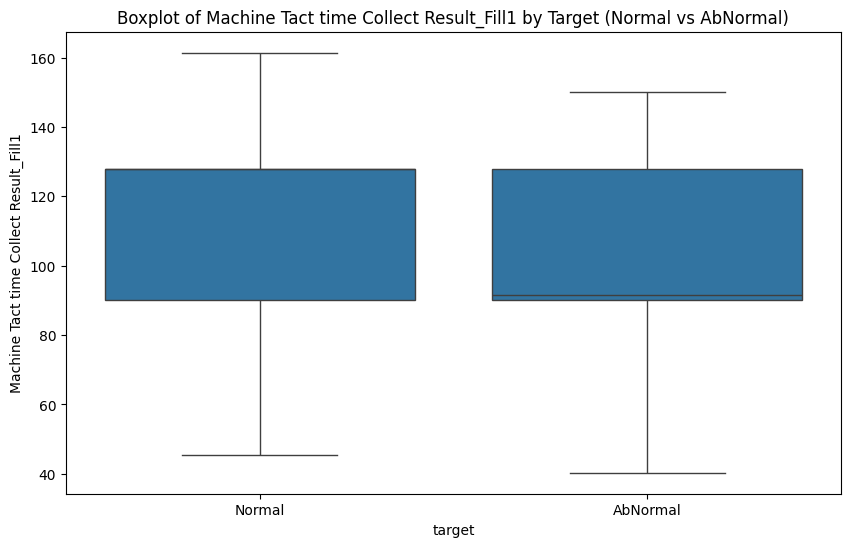

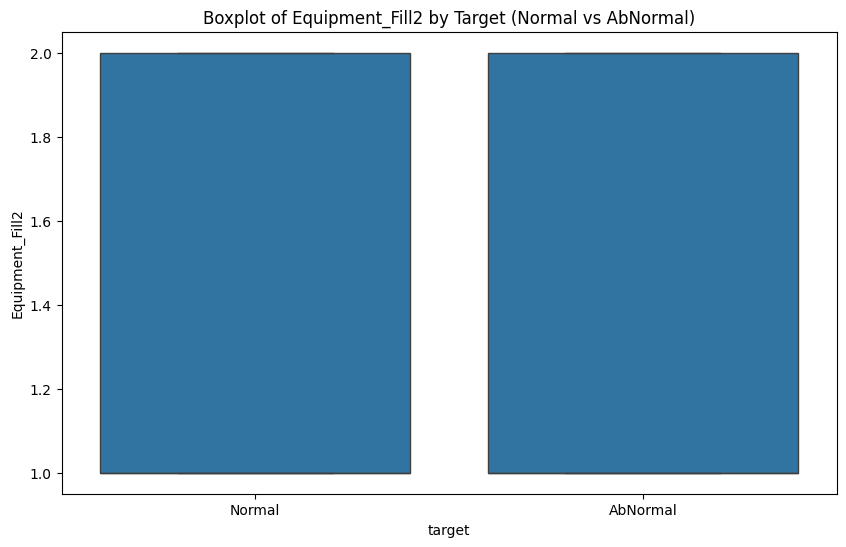

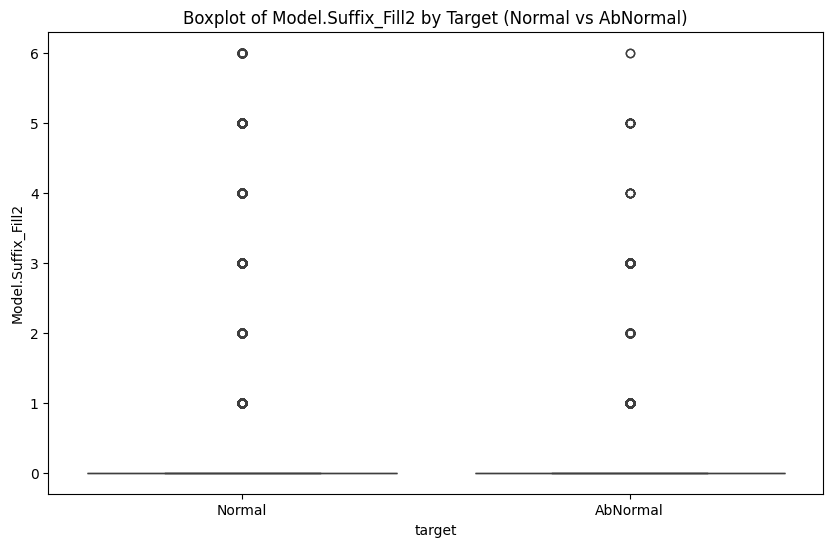

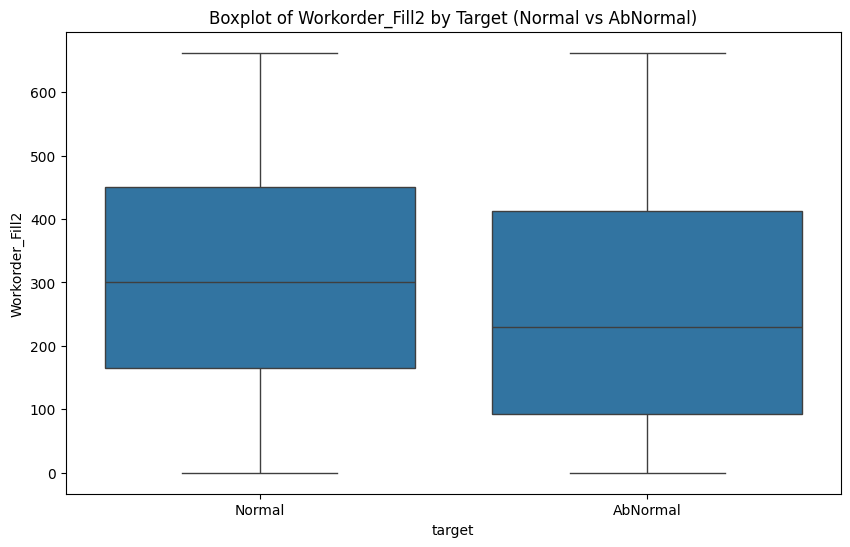

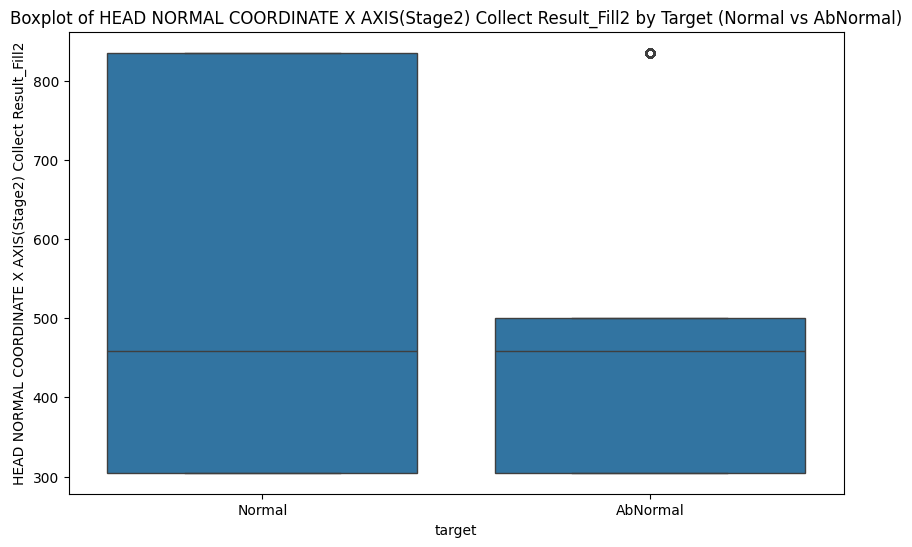

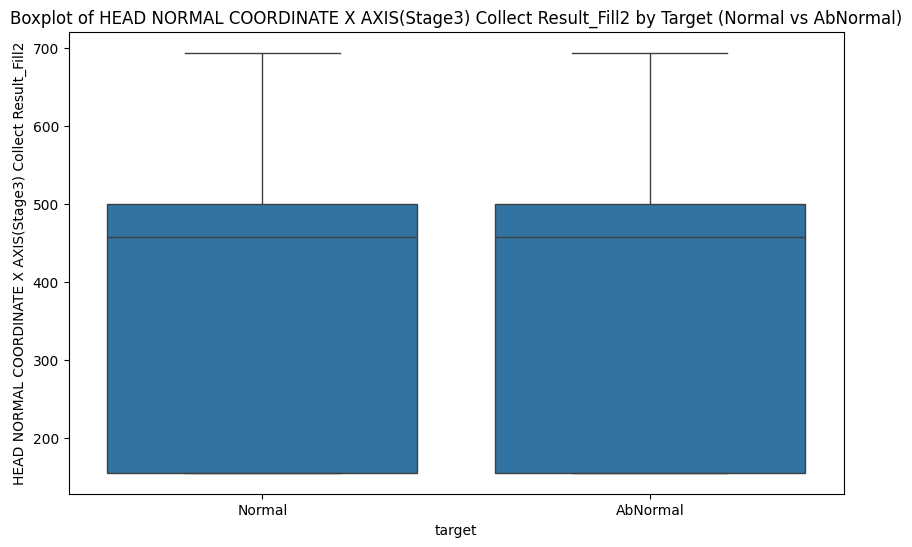

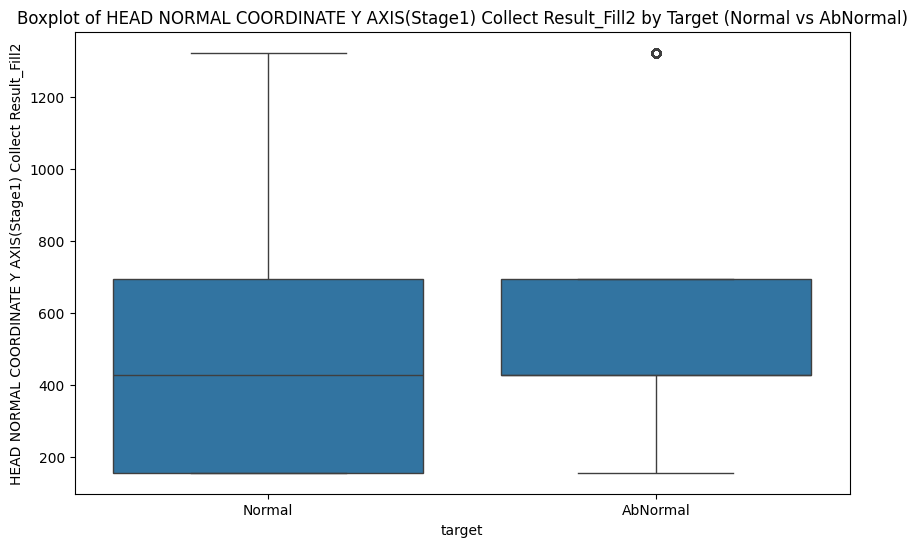

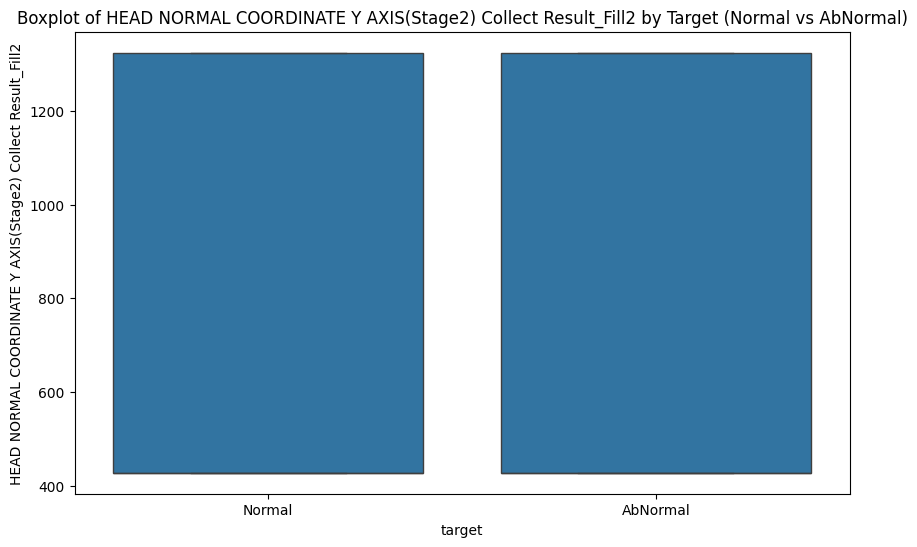

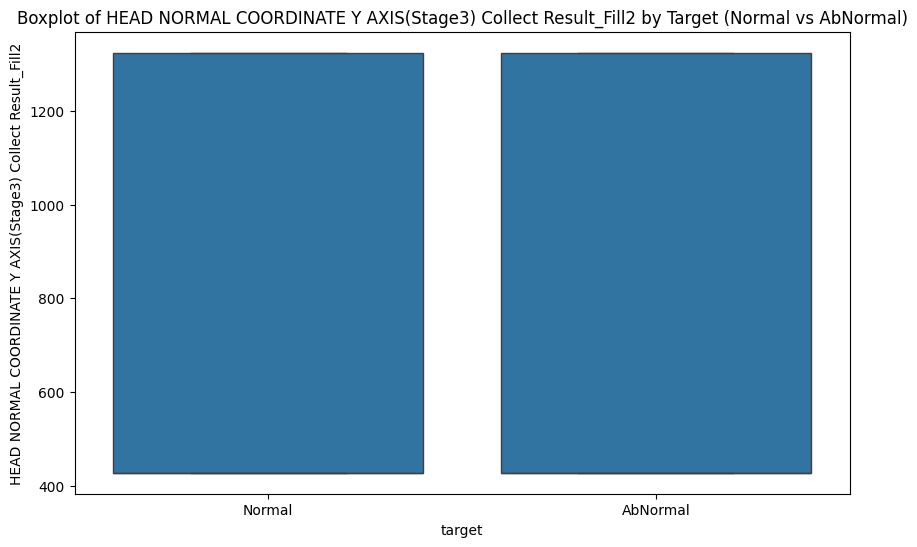

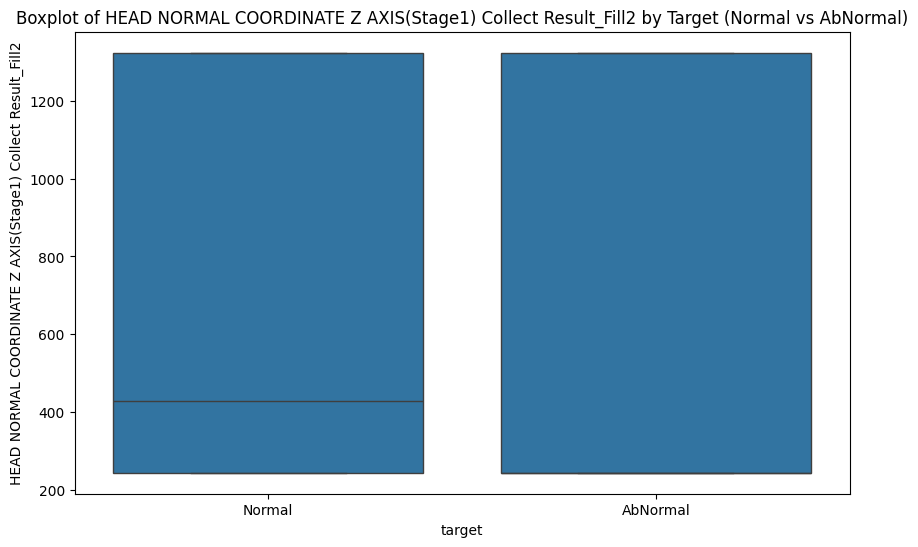

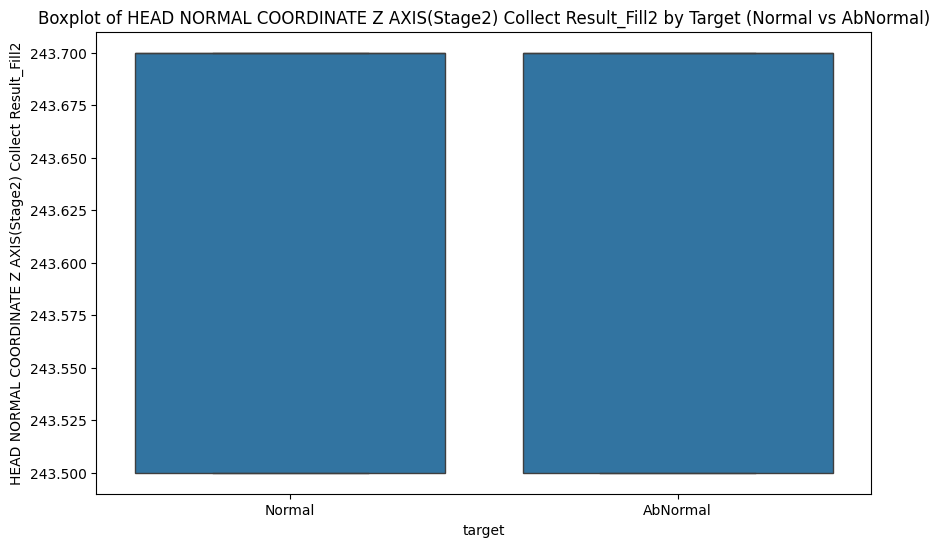

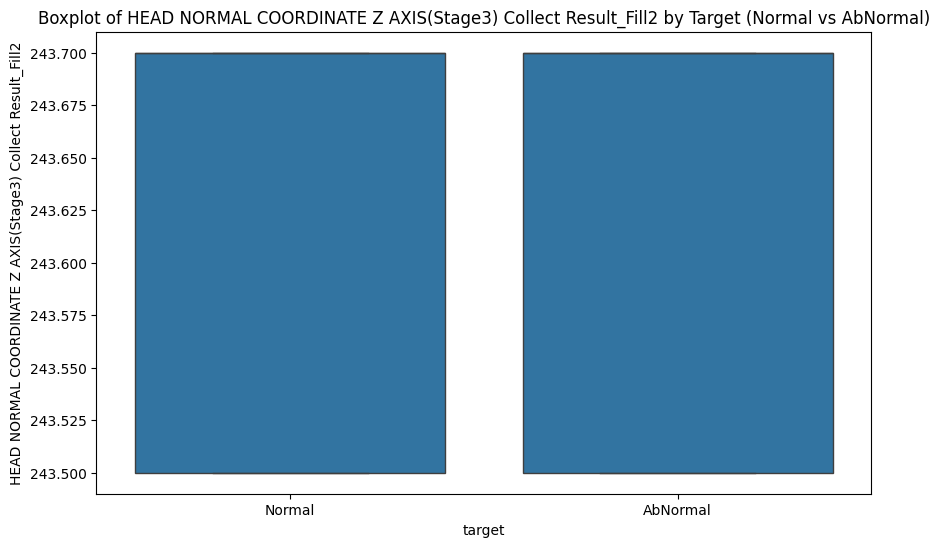

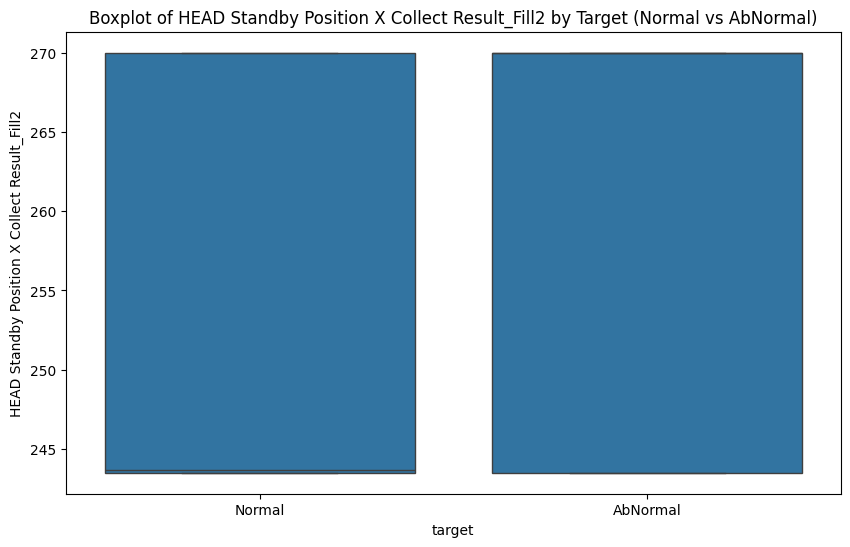

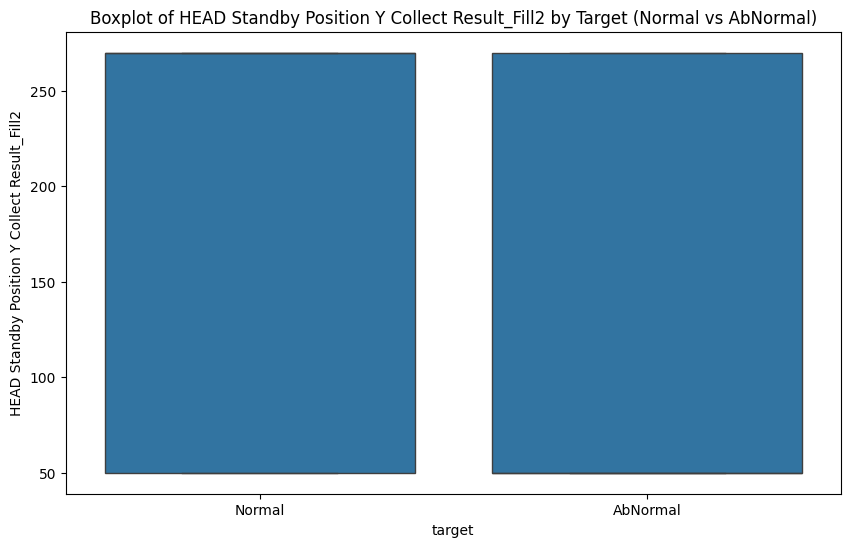

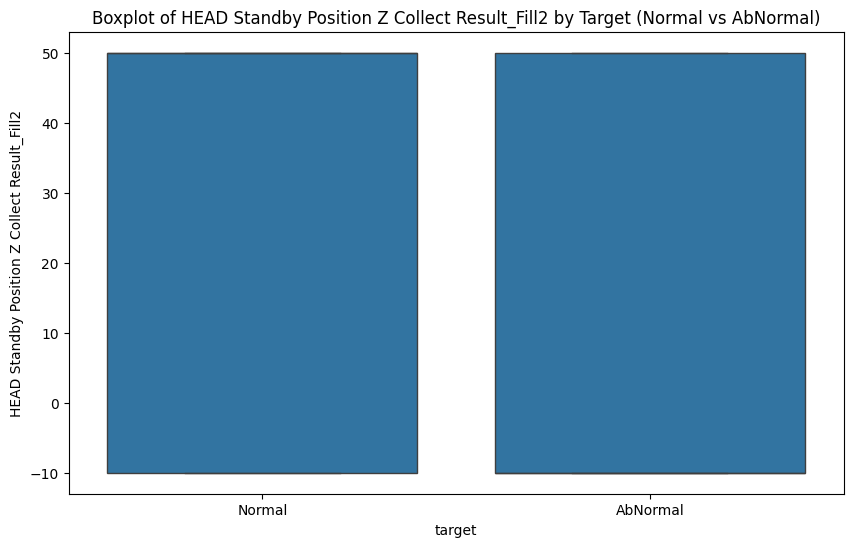

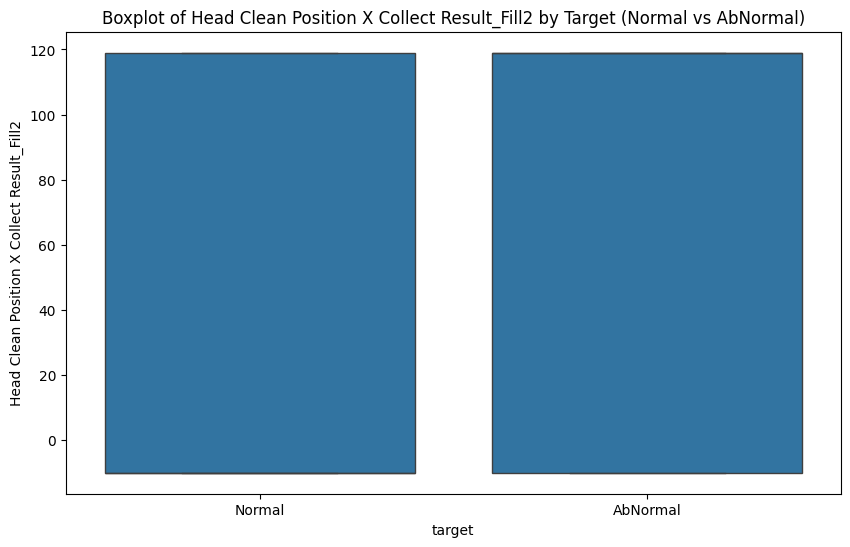

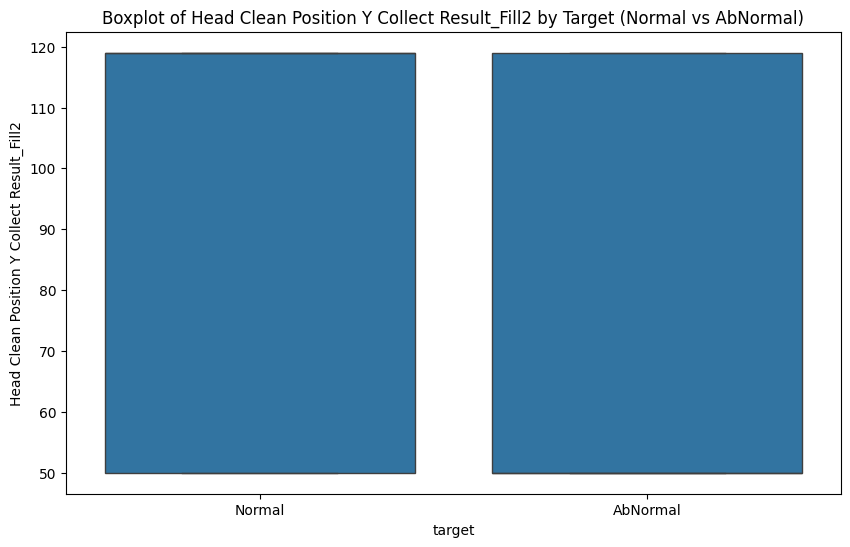

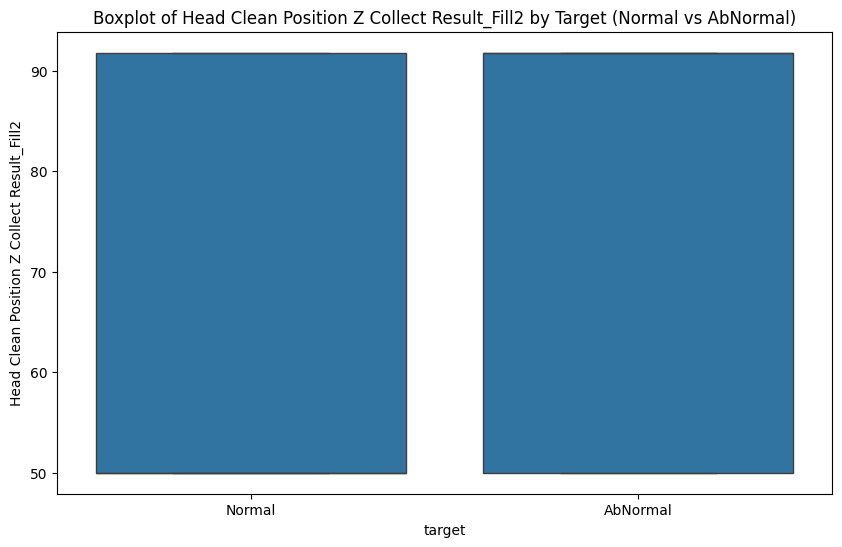

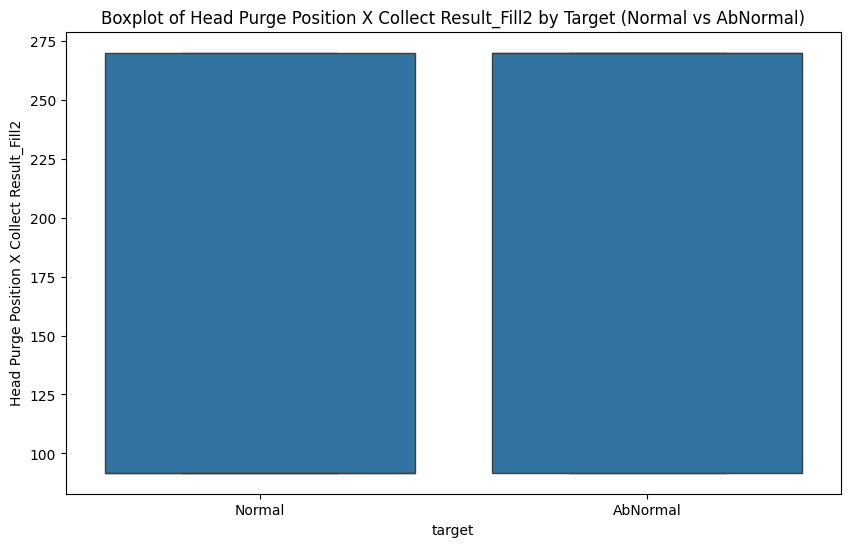

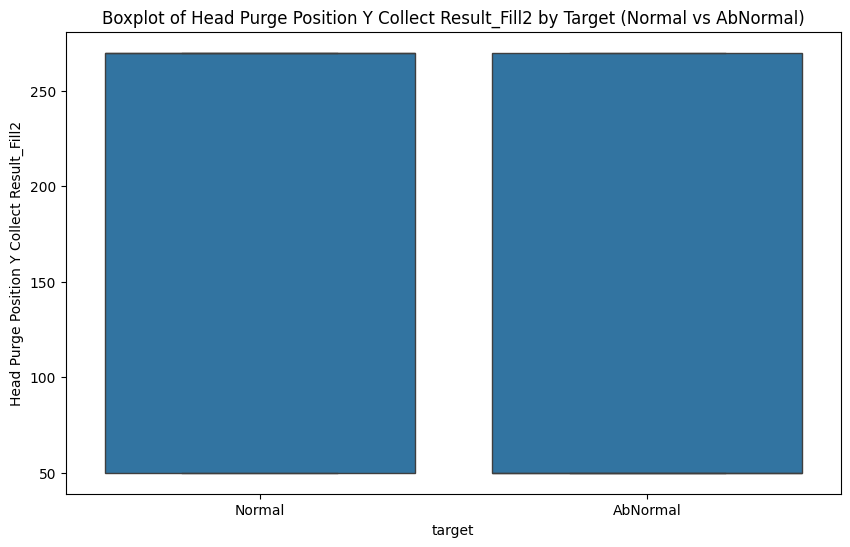

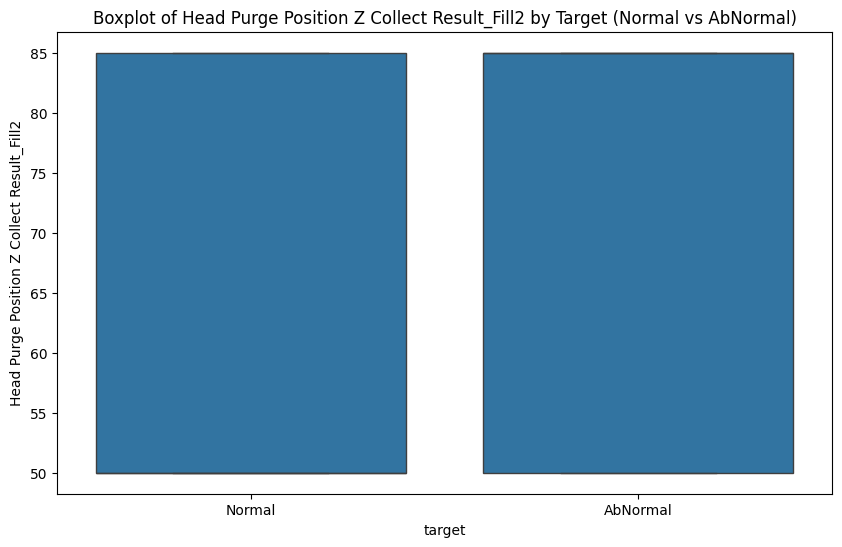

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 타겟 값 'Normal'과 'AbNormal'에 따른 Boxplot을 그리기
# target 칼럼을 제외한 나머지 칼럼을 Boxplot으로 시각화
for column in train_data.columns.drop('target'):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='target', y=column, data=train_data)
    plt.title(f'Boxplot of {column} by Target (Normal vs AbNormal)')
    plt.show()

In [ ]:
# 임계값 설정 (중앙값 차이 기준)
threshold = 0.005  # 중앙값 차이가 5% 이하이면 유사한 분포로 간주

# 중앙값 차이가 작은 칼럼들을 제외한 새로운 데이터프레임 만들기
columns_to_drop = []  # 제외할 칼럼들을 저장하는 리스트

for column in train_data.columns.drop('target'):
    # Normal과 AbNormal에 따른 중앙값 계산
    median_normal = train_data[train_data['target'] == 'Normal'][column].median()
    median_abnormal = train_data[train_data['target'] == 'AbNormal'][column].median()

    # 중앙값 차이 계산
    median_diff = abs(median_normal - median_abnormal)

    # 중앙값 차이가 threshold 이하인 경우 해당 칼럼을 제외할 리스트에 추가
    if median_diff < threshold:
        columns_to_drop.append(column)

# 제외할 칼럼들을 원래 데이터에서 제거
train_data = train_data.drop(columns=columns_to_drop)
train_data

Workorder_Dam  DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam  \
0                657                                                  8.4   
1                283                                                  4.9   
2                589                                                  8.5   
3                251                                                  8.4   
4                142                                                  4.9   
...              ...                                                  ...   
40501            238                                                  5.0   
40502            643                                                  8.5   
40503            540                                                  8.2   
40504            164                                                  4.9   
40505             46                                                  3.9   

       Dispense Volume(Stage2) Collect Result_Dam  \
0                                            0.58   
1                                            0.34   
2                                            0.93   
3                                            0.58   
4                                            0.34   
...                                           ...   
40501                                        0.35   
40502                                        0.59   
40503                                        0.57   
40504                                        0.34   
40505                                        0.27   

       Dispense Volume(Stage3) Collect Result_Dam  \
0                                            1.02   
1                                            1.49   
2                                            1.61   
3                                            1.49   
4                                            0.67   
...                                           ...   
40501                                        1.19   
40502                                        1.02   
40503                                        1.00   
40504                                        0.67   
40505                                        0.67   

       HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam  \
0                                                         550.5   
1                                                         463.8   
2                                                         162.4   
3                                                         465.5   
4                                                         462.5   
...                                                         ...   
40501                                                     463.8   
40502                                                     163.5   
40503                                                     550.6   
40504                                                     465.1   
40505                                                     463.0   

       HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam  \
0                                                         464.3   
1                                                         160.8   
2                                                         465.4   
3                                                         552.0   
4                                                         159.5   
...                                                         ...   
40501                                                     160.8   
40502                                                     466.2   
40503                                                     463.9   
40504                                                     551.3   
40505                                                     160.5   

       HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam  \
0                                                        384.00   
1                                                        282.15 

In [ ]:
# pandas 옵션 설정: 모든 칼럼명 출력
pd.set_option('display.max_colwidth', None)

# target 변환: 'Normal'을 0, 'AbNormal'을 1로 변환
train_data['target_numeric'] = train_data['target'].replace({'Normal': 0, 'AbNormal': 1})

# 독립 변수와 변환된 종속 변수 분리
X = train_data.drop(columns=['target', 'target_numeric'])  # 원래 target 컬럼과 숫자로 변환된 target 둘 다 제외
y = train_data['target_numeric']
z = train_data['target']
# CatBoost 모델 학습
model = CatBoostClassifier(random_state=RANDOM_STATE, verbose=0)
model.fit(X, y)

# 피처 중요도 추출
feature_importances = model.get_feature_importance()

# 피처 중요도를 데이터프레임으로 변환 후 정렬
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

# 중요도가 높은 상위 10개 피처 선택
top_10_features = importance_df.head(10)

# 결과 출력
print(top_10_features)

                                                     feature  importance
0                                              Workorder_Dam   10.967873
29                                       Workorder_AutoClave   10.566936
30                                           Workorder_Fill1    9.318418
44                    Machine Tact time Collect Result_Fill1    8.560542
45                                           Workorder_Fill2    8.329047
3                 Dispense Volume(Stage3) Collect Result_Dam    7.020918
1        DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam    5.621452
4   HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam    5.468335
2                 Dispense Volume(Stage2) Collect Result_Dam    4.426592
5   HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam    3.886215


In [ ]:
top_10 = [
    'Workorder_Dam',
    'Workorder_AutoClave',
    'Workorder_Fill1',
    'Machine Tact time Collect Result_Fill1',
    'Workorder_Fill2',
    'Dispense Volume(Stage3) Collect Result_Dam',
    'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam',
    'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam',
    'Dispense Volume(Stage2) Collect Result_Dam',
    'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'
]

train_data = pd.concat([train_data[top_10],z], axis=1)
train_data

Workorder_Dam  Workorder_AutoClave  Workorder_Fill1  \
0                657                  657              657   
1                283                  283              283   
2                589                  589              589   
3                251                  251              251   
4                142                  142              142   
...              ...                  ...              ...   
40501            238                  238              238   
40502            643                  643              643   
40503            540                  540              540   
40504            164                  164              164   
40505             46                   46               46   

       Machine Tact time Collect Result_Fill1  Workorder_Fill2  \
0                                       128.0              657   
1                                        56.5              283   
2                                       128.0              589   
3                                        57.7              251   
4                                        89.9              142   
...                                       ...              ...   
40501                                    51.8              238   
40502                                   128.0              643   
40503                                   128.0              540   
40504                                    57.4              164   
40505                                    91.5               46   

       Dispense Volume(Stage3) Collect Result_Dam  \
0                                            1.02   
1                                            1.49   
2                                            1.61   
3                                            1.49   
4                                            0.67   
...                                           ...   
40501                                        1.19   
40502                                        1.02   
40503                                        1.00   
40504                                        0.67   
40505                                        0.67   

       DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam  \
0                                                      8.4   
1                                                      4.9   
2                                                      8.5   
3                                                      8.4   
4                                                      4.9   
...                                                    ...   
40501                                                  5.0   
40502                                                  8.5   
40503                                                  8.2   
40504                                                  4.9   
40505                                                  3.9   

       HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam  \
0                                                         550.5   
1                                                         463.8   
2                                                         162.4   
3                                                         465.5   
4                                                         462.5   
...                                                         ...   
40501                                                     463.8   
40502                                                     163.5   
40503                                                     550.6   
40504                                                     465.1   
40505                                                     463.0   

       Dispense Volume(Stage2) Collect Result_Dam  \
0                                            0.58   
1                                            0.34   
2                                            0.93   
3                                            0.58   
4                

### 오버 샘플링


데이타 불균형을 해결하기 위해 오버 샘플링을 진행합니다.


In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.model_selection import train_test_split

# 1. 데이터 준비 (train_data에서 target 분리)
X = train_data.drop(columns=['target'])  # Features (target 칼럼 제외)
y = train_data['target']  # Target (Normal, AbNormal)

# 2. LabelEncoder로 라벨 인코딩 (Normal=0, AbNormal=1)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # LabelEncoding (Normal -> 0, AbNormal -> 1)

# 3. SMOTE 적용 (1:1 비율로 오버샘플링)
smote = SMOTE(sampling_strategy='minority', random_state=RANDOM_STATE)
X_smote, y_smote = smote.fit_resample(X, y_encoded)

# 4. 원래 라벨로 다시 변환
y_smote = label_encoder.inverse_transform(y_smote)

# 5. 오버샘플링된 데이터의 새로운 데이터프레임 생성
df_concat = pd.concat([pd.DataFrame(X_smote, columns=X.columns), pd.DataFrame(y_smote, columns=['target'])], axis=1)

# 6. 오버샘플링 후 데이터 분포 확인
print(df_concat['target'].value_counts())

target
Normal      38156
AbNormal    38156
Name: count, dtype: int64


### 데이터 분할


In [ ]:
# Train/Test Split
df_train, df_val = train_test_split(
    df_concat,
    test_size=0.2,
    stratify=df_concat["target"],
    random_state=RANDOM_STATE,
)

# 통계 함수 개선
def print_stats(df: pd.DataFrame):
    num_normal = len(df[df["target"] == "Normal"])
    num_abnormal = len(df[df["target"] == "AbNormal"])

    print(f"  Total: Normal: {num_normal}, AbNormal: {num_abnormal}, " +
          f"Ratio: {num_abnormal / num_normal:.2f}")

# Print statistics
print(f"  \tAbnormal\tNormal")
print_stats(df_train)
print_stats(df_val)

  	Abnormal	Normal
  Total: Normal: 30525, AbNormal: 30524, Ratio: 1.00
  Total: Normal: 7631, AbNormal: 7632, Ratio: 1.00


## 3. 모델 학습


### 모델 정의


In [ ]:
#Trial 11 finished with value: 0.8609847780971167 and parameters: {'xgb_n_estimators': 1037, 'xgb_max_depth': 15, 'xgb_learning_rate': 0.00016293015158765526, 'xgb_subsample': 0.5014671604431905, 'xgb_colsample_bytree': 0.8531522873758013, 'xgb_scale_pos_weight': 1.2364249635896376, 'cat_iterations': 1928, 'cat_depth': 9, 'cat_learning_rate': 0.032694393777846005, 'cat_l2_leaf_reg': 1.11808066262774, 'lgb_n_estimators': 1351, 'lgb_max_depth': 12, 'lgb_learning_rate': 0.009840749403771509, 'lgb_num_leaves': 128, 'lgb_min_child_samples': 12, 'lgb_subsample': 0.8446281864536254, 'lgb_colsample_bytree': 0.5953868312722675, 'lgb_scale_pos_weight': 2.232291375119889}. Best is trial 11 with value: 0.8609847780971167.

In [ ]:
cat_best_param = {
    'iterations': 1336,
    'depth': 12,
    'learning_rate': 0.041666861411792266,
    'l2_leaf_reg': 3.6534440278046287,
    'random_strength': 1.3658302260805186,
    'bagging_temperature': 0.1080013775783566
}

In [ ]:
# 최적의 하이퍼파라미터로 최종 모델 구성
cat_final_model = CatBoostClassifier(**cat_best_param, verbose=0)

### 모델 학습


In [ ]:
features = []

for col in df_train.columns:
    try:
        df_train[col] = df_train[col].astype(int)
        features.append(col)
    except:
        continue

train_x = df_train[features]
train_y = df_train["target"]

cat_final_model.fit(train_x, train_y)

## 4. 제출하기


### 테스트 데이터 예측


테스트 데이터 불러오기


In [ ]:
test_data = pd.read_csv(os.path.join(ROOT_DIR, "test.csv"))
df_test_x = test_data[features]
df_test_x

drop_columns = ['Workorder_Dam', 'Workorder_AutoClave', 'Workorder_Fill1', 'Workorder_Fill2']

# LabelEncoder 생성
label_encoder = LabelEncoder()

# 각 열에 대해 Label Encoding을 적용하여 새로운 열을 추가하고, 기존 열을 삭제
for col in drop_columns:
    df_test_x[col] = label_encoder.fit_transform(df_test_x[col])

/tmp/ipykernel_55/2973812884.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_x[col] = label_encoder.fit_transform(df_test_x[col])
/tmp/ipykernel_55/2973812884.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_x[col] = label_encoder.fit_transform(df_test_x[col])
/tmp/ipykernel_55/2973812884.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

In [ ]:
for col in df_test_x.columns:
    try:
        df_test_x.loc[:, col] = df_test_x[col].astype(int)
    except:
        continue

In [ ]:
# CatBoost 예측
test_pred = cat_final_model.predict(df_test_x)
print(test_pred)

['AbNormal' 'Normal' 'AbNormal' ... 'AbNormal' 'AbNormal' 'Normal']


### 제출 파일 작성


In [ ]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["target"] = test_pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

**우측 상단의 제출 버튼을 클릭해 결과를 확인하세요**
